<a href="https://colab.research.google.com/github/yodavo/moja-global-analysis/blob/main/David_Guevara_Climate_Shift_Visuals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install and import condalab, run twice.
!pip install -q condacolab -q
import condacolab
condacolab.install()

# install geopandas, this could take long
!conda install geopandas
import geopandas as gpd

✨🍰✨ Everything looks OK!
Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

# All requested packages already installed.



In [2]:
# for download and decompress the dataset
import os, zipfile, glob, io, requests

# for SIG and spatial info management
from shapely.geometry import Polygon, shape

# for SIG and spatial visualization
import folium
from folium import Choropleth
from folium.plugins import HeatMap

# for dataframes and numerical info management
import numpy as np
import pandas as pd

# for plot and graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warning about missing/empty geometries
import warnings
warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
plt.rcParams.update({'figure.max_open_warning': 0})

# **Importing data and creating dataframes**

## **0. Boundaries for clipping**

In [3]:
# fetching from the repo
! wget https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip

#### Wold boundary ####
world_df = gpd.read_file("/content/ne_110m_admin_0_countries.zip")
world_df.to_crs(epsg=4326, inplace=True)

# also the dataset is huge (162 features), so it need cleaning.
world_df = world_df[['CONTINENT','NAME_LONG', 'POP_EST', 'POP_YEAR', 'LASTCENSUS', 'geometry']]
world_df.columns = world_df.columns.str.lower()

#### South America ####
south_america_df = world_df.loc[world_df.continent == 'South America',]

# fixing data
south_america_df = south_america_df.reset_index(drop=True)
south_america_df.lastcensus = south_america_df.lastcensus.astype(str).replace({'-99':'1999'}).astype(int)
south_america_df['popu'] = south_america_df['pop_est'] / 1e6 # get the population in millions

# ### Peru boundary dataset ####
peru_df = world_df.loc[world_df.name_long == 'Peru',]
peru_df = peru_df.reset_index(drop=True)

# Peruvian 'Departamentos' choosed for review: Cusco and Madre de Dios.

# state (Departamento) dataset
mdiosBoundary_df = 'https://datasets.mojaglobal.workers.dev/0:/Administrative/Boundaries/Level4%20by%20State/PER/PER_AL4_Madre%20de%20Dios.json'
cuscoBoundary_df = 'https://datasets.mojaglobal.workers.dev/0:/Administrative/Boundaries/Level4%20by%20State/PER/PER_AL4_Cusco.json'

# download the data with request
mdiosBoundary_df = requests.get(mdiosBoundary_df).content
cuscoBoundary_df = requests.get(cuscoBoundary_df).content

# load the json with geopandas and set crs
mdiosBoundary_df = gpd.read_file(io.StringIO(mdiosBoundary_df.decode('utf-8')))
mdiosBoundary_df = mdiosBoundary_df[['name', 'geometry']]
mdiosBoundary_df.set_crs(epsg=4326, inplace=True)
cuscoBoundary_df = gpd.read_file(io.StringIO(cuscoBoundary_df.decode('utf-8')))
cuscoBoundary_df = cuscoBoundary_df[['name', 'geometry']]
cuscoBoundary_df.set_crs(epsg=4326, inplace=True)

# fix the georeference! the map seems to be cliped from a bad reference
mdiosBoundary_df.to_crs(5389, inplace=True)
mdiosBoundary_df.to_crs(4326, inplace=True) 
cuscoBoundary_df.to_crs(5389, inplace=True)
cuscoBoundary_df.to_crs(4326, inplace=True)

# Using pandas to concatenate the dataframes. This is so cool!
regionsBoundary_df = pd.concat([mdiosBoundary_df, cuscoBoundary_df], ignore_index=True)

--2021-11-05 02:12:49--  https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip
Resolving www.naturalearthdata.com (www.naturalearthdata.com)... 50.87.253.14
Connecting to www.naturalearthdata.com (www.naturalearthdata.com)|50.87.253.14|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip [following]
--2021-11-05 02:13:11--  https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip
Resolving naciscdn.org (naciscdn.org)... 13.32.150.16, 13.32.150.13, 13.32.150.45, ...
Connecting to naciscdn.org (naciscdn.org)|13.32.150.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 204507 (200K) [application/zip]
Saving to: ‘ne_110m_admin_0_countries.zip’

ne_110m_admin_0_cou 100%[===================>] 199.71K   757KB/s    in 0.3s    

2021-11-05 02:13:12 (757 KB/s) - ‘ne_110m_ad

The boundaries dataset summaries:

  * `world_df` - **World boundaries** - (Level 0)
  * `southamerica_df` - **South American boundaries** - Clipped from (*world_df*).
  * `peru_df` - **Peruvian Administrative boundaries** (Level 2).
    * `mdiosBoundary_df` - **boundary of Madre de Dios Province** (Level 4) NOTE: crs correction.
    * `cuscoBoundary_df` - **boundary of Cusco Province** (Level 4) NOTE: crs correction.
    * `regionsBoundary_df` - **boundaries of both Peruvian Provinces**



## **Koppen-Geiger Climate Changes (1901 - 2100)**



In [4]:
# Load the data and prepare the datasets
!wget 'https://datasets.mojaglobal.workers.dev/0:/Climate/KoppenGeiger_ClimateShifts1901_2100/KoppenGeigerClimateShifts.zip'
with zipfile.ZipFile('KoppenGeigerClimateShifts.zip', 'r') as shifts:
  shifts.extractall("shifts")

# remove zip
%rm KoppenGeigerClimateShifts.zip

# path to the folder
files = glob.glob(os.path.join('/content/shifts', '*geojson'))

--2021-11-05 02:13:17--  https://datasets.mojaglobal.workers.dev/0:/Climate/KoppenGeiger_ClimateShifts1901_2100/KoppenGeigerClimateShifts.zip
Resolving datasets.mojaglobal.workers.dev (datasets.mojaglobal.workers.dev)... 172.67.201.202, 104.21.60.214, 2606:4700:3035::6815:3cd6, ...
Connecting to datasets.mojaglobal.workers.dev (datasets.mojaglobal.workers.dev)|172.67.201.202|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2872855 (2.7M) [application/x-zip-compressed]
Saving to: ‘KoppenGeigerClimateShifts.zip’

KoppenGeigerClimate 100%[===================>]   2.74M  --.-KB/s    in 0.06s   

2021-11-05 02:13:29 (42.2 MB/s) - ‘KoppenGeigerClimateShifts.zip’ saved [2872855/2872855]



In [5]:
# Rename and arrange the information
# prepare names
names = [i[16:25]+ '_' + i[26:28] for i in files]  

# prepare the files
files_loaded = [gpd.read_file(f) for f in files]

# merging all the metadata
koppen = list(zip(names, files_loaded))

# print the results
print('%2d dataset were imported for shift in climate Zones.' %(len(koppen)))

20 dataset were imported for shift in climate Zones.


In [6]:
# fixing the data, adding abbreviations and koppen-geiger terms

# the Koppen-Geiger system
koppen_abb = {'11': 'Af', '12': 'Am', '13': 'As', '14': 'Aw', '21': 'BWk', 
              '22': 'BWh', '26': 'BSk', '27': 'BSh', '31': 'Cfa', 
              '32': 'Cfb', '33': 'Cfc', '34': 'Csa', '35': 'Csb', 
              '36': 'Csc', '37': 'Cwa', '38': 'Cwb', '39': 'Cwc', 
              '41': 'Dfa', '42': 'Dfb', '43': 'Dfc', '44': 'Dfd', 
              '45': 'Dsa', '46': 'Dsb', '47': 'Dsc', '48': 'Dsd', 
              '49': 'Dwa', '50': 'Dwb', '51': 'Dwc', '52': 'Dwd', 
              '61': 'EF', '62': 'ET', '0': 'NaN'}

koppen_term ={'Af' : 'Tropical rainforest climate', 'Am' : 'Tropical monsoon climate', 
              'As' : 'Tropical savanna climate with dry-summer characteristics', 
              'Aw' : 'Tropical savanna climate with dry-winter characteristics', 
              'BWk' : 'Cold desert climate', 'BWh' : 'Hot desert climate', 
              'BSk' : 'Cold semi-arid climate', 'BSh' : 'Hot semi-arid climate', 
              'Cfa' : 'Humid subtropical climate;', 'Cfb' : 'Temperate oceanic climate', 
              'Cfc' : 'Subpolar oceanic climate', 'Csa' : 'Hot-summer Mediterranean climate', 
              'Csb' : 'Warm-summer Mediterranean climate', 'Csc' : 'Cold-summer Mediterranean climate', 
              'Cwa' : 'Monsoon-influenced humid subtropical climate', 'Cwb' : 'Subtropical highland climate', 
              'Cwc' : 'Cold subtropical highland climate', 'Dfa' : 'Hot-summer humid continental climate', 
              'Dfb' : 'Warm-summer humid continental climate', 'Dfc' : 'Subarctic climate', 
              'Dfd' : 'Extremely cold subarctic climate', 'Dsa' : 'Mediterranean-influenced hot-summer humid continental climate', 
              'Dsb' : 'Mediterranean-influenced warm-summer humid continental climate', 
              'Dsc' : 'Mediterranean-influenced subarctic climate', 'Dsd' : 'Mediterranean-influenced extremely cold subarctic climate', 
              'Dwa' : 'Monsoon-influenced hot-summer humid continental climate', 'Dwb' : 'Monsoon-influenced warm-summer humid continental climate', 
              'Dwc' : 'Monsoon-influenced subarctic climate', 'Dwd' : 'Monsoon-influenced extremely cold subarctic climate', 
              'EF' : 'Ice cap climate', 'ET' : 'Tundra climate'}

# replacing in all the dataframes
for i in koppen:
  name, df = i
  
  # fixing df, lower columns
  df.columns = df.columns.str.lower()

  # mapping abbreviations
  df['gridcode'] = df['gridcode'].fillna(0) # handle empty
  df['gridcode'] = df['gridcode'].astype(int) # coercing for replace
  df['abb'] = df.gridcode.astype(str).replace(koppen_abb)
  
  # mappin name
  df['koppen'] = df.abb.replace(koppen_term)

### **Plot and get area functions**

In [7]:
# Plotting function - for horizontal
def plot_shift(df_list):
  font = {'family': 'serif',
          'color':  'darkred',
          'weight': 'normal',
          'size': 30,
          }

  fig, axs = plt.subplots(2,2, figsize=(30, 15), facecolor='w', edgecolor='k')

  for ax, i in zip(axs.ravel(),df_list) :
    name, df = i
    #name correction
    if '_' in name:
      name = name.replace('_', ' in ')

    df.set_crs(epsg=4326, inplace=True)
    df.plot(ax = ax, column='abb', cmap='tab20c',
            legend=True, legend_kwds= {'ncol': 3, 'loc': 'lower left'})
    ax.set_title(str(name), fontdict=font)
  plt.tight_layout()
  plt.show()

In [8]:
# Plotting function - for south america - peru
def plot_shiftv(df_list):
  font = {'family': 'serif',
          'color':  'darkred',
          'weight': 'normal',
          'size': 25,
          }

  fig, axs = plt.subplots(5,4, figsize=(24,40), facecolor='w', edgecolor='k')

  for ax, i in zip(axs.ravel(),df_list) :
    name, df = i
    #name correction
    if '_' in name:
      name = name.replace('_', ' in ')
    df.set_crs(epsg=4326, inplace=True)
    df.plot(ax = ax, column='koppen', cmap='tab20c',
            legend=True)
    ax.set_title(str(name), fontdict=font)

    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    ax.get_legend().remove() # remove subplot legend
  
  plt.legend(lines, labels)
  plt.tight_layout()
  plt.show()

In [9]:
# get area
def get_area(lista):
  nueva_lista = []
  for i in lista:
    name, df = i   
    df['area_km2'] = df.geometry.area / 1e-6
    nueva_lista.append((name, df))
  return nueva_lista

# **Datasets arrangement**

In [10]:
#### 1. Shifts bases on observations ####
observations_world = []
for i in koppen:
  name, df = i
  if name[-2:] == 'ge':
    observations_world.append((name[:-3], df))
# sorting the list by year
observations_world = sorted(observations_world, key = lambda x: int(x[0][0:3]))

#### 2. A1F1 Emision Scenarios ####
a1f1_world = []
for i in koppen:
  name, df = i
  if name[-2:] == 'A1':
    a1f1_world.append((name +'F1', df))
# sorting the list by year
a1f1_world = sorted(a1f1_world, key = lambda x: int(x[0][0:3]))

### 3. A2 Emissions Scenarios ####
a2_world = []
for i in koppen:
  name, df = i
  if name[-2:] == 'A2':
    a2_world.append((name, df))
# sorting the list by year
a2_world = sorted(a2_world, key = lambda x: int(x[0][0:3]))

#### 4. B1 Emissions Scenarios ####
b1_world = []
for i in koppen:
  name, df = i
  if name[-2:] == 'B1':
    b1_world.append((name, df))
# sorting the list by year
b1_world = sorted(b1_world, key = lambda x: int(x[0][0:3]))

#### 5. B2 Emissions Scenarios ####
b2_world = []
for i in koppen:
  name, df = i
  if name[-2:] == 'B2':
    b2_world.append((name, df))
# sorting the list by year
b2_world = sorted(b2_world, key = lambda x: int(x[0][0:3]))



# **Cropping in South America, Peru and Region_estudio**

In [11]:
# function to extract
def crop_geodf(lista, clipped):
  cropped = []
  for i in lista:
    name, df = i
    temp = df.clip(clipped)
    temp = temp.reset_index(drop=True)
    cropped.append((name, temp))
  return cropped

In [140]:
# cropping all databases in south america
obs_southamerica = crop_geodf(observations_world, south_america_df)
a1_southamerica = crop_geodf(a1f1_world, south_america_df)
a2_southamerica = crop_geodf(a2_world, south_america_df)
b1_southamerica = crop_geodf(b1_world, south_america_df)
b2_southamerica = crop_geodf(b2_world, south_america_df)

# merging 
southamerica = obs_southamerica + a1_southamerica + a2_southamerica + b1_southamerica + b2_southamerica

In [148]:
# cropping all databases in peru
obs_peru = crop_geodf(observations_world, peru_df)
a1_peru = crop_geodf(a1f1_world, peru_df)
a2_peru = crop_geodf(a2_world, peru_df)
b1_peru = crop_geodf(b1_world, peru_df)
b2_peru = crop_geodf(b2_world, peru_df)

# merging 
peru = obs_peru + a1_peru + a2_peru + b1_peru + b2_peru

In [142]:
# cropping all databases in region
obs_region = crop_geodf(observations_world, regionsBoundary_df)
a1_region = crop_geodf(a1f1_world, regionsBoundary_df)
a2_region = crop_geodf(a2_world, regionsBoundary_df)
b1_region = crop_geodf(b1_world, regionsBoundary_df)
b2_region = crop_geodf(b2_world, regionsBoundary_df)

# region
region_estudio = obs_region + a1_region + a2_region + b1_region + b2_region

# **Analysis in South America**

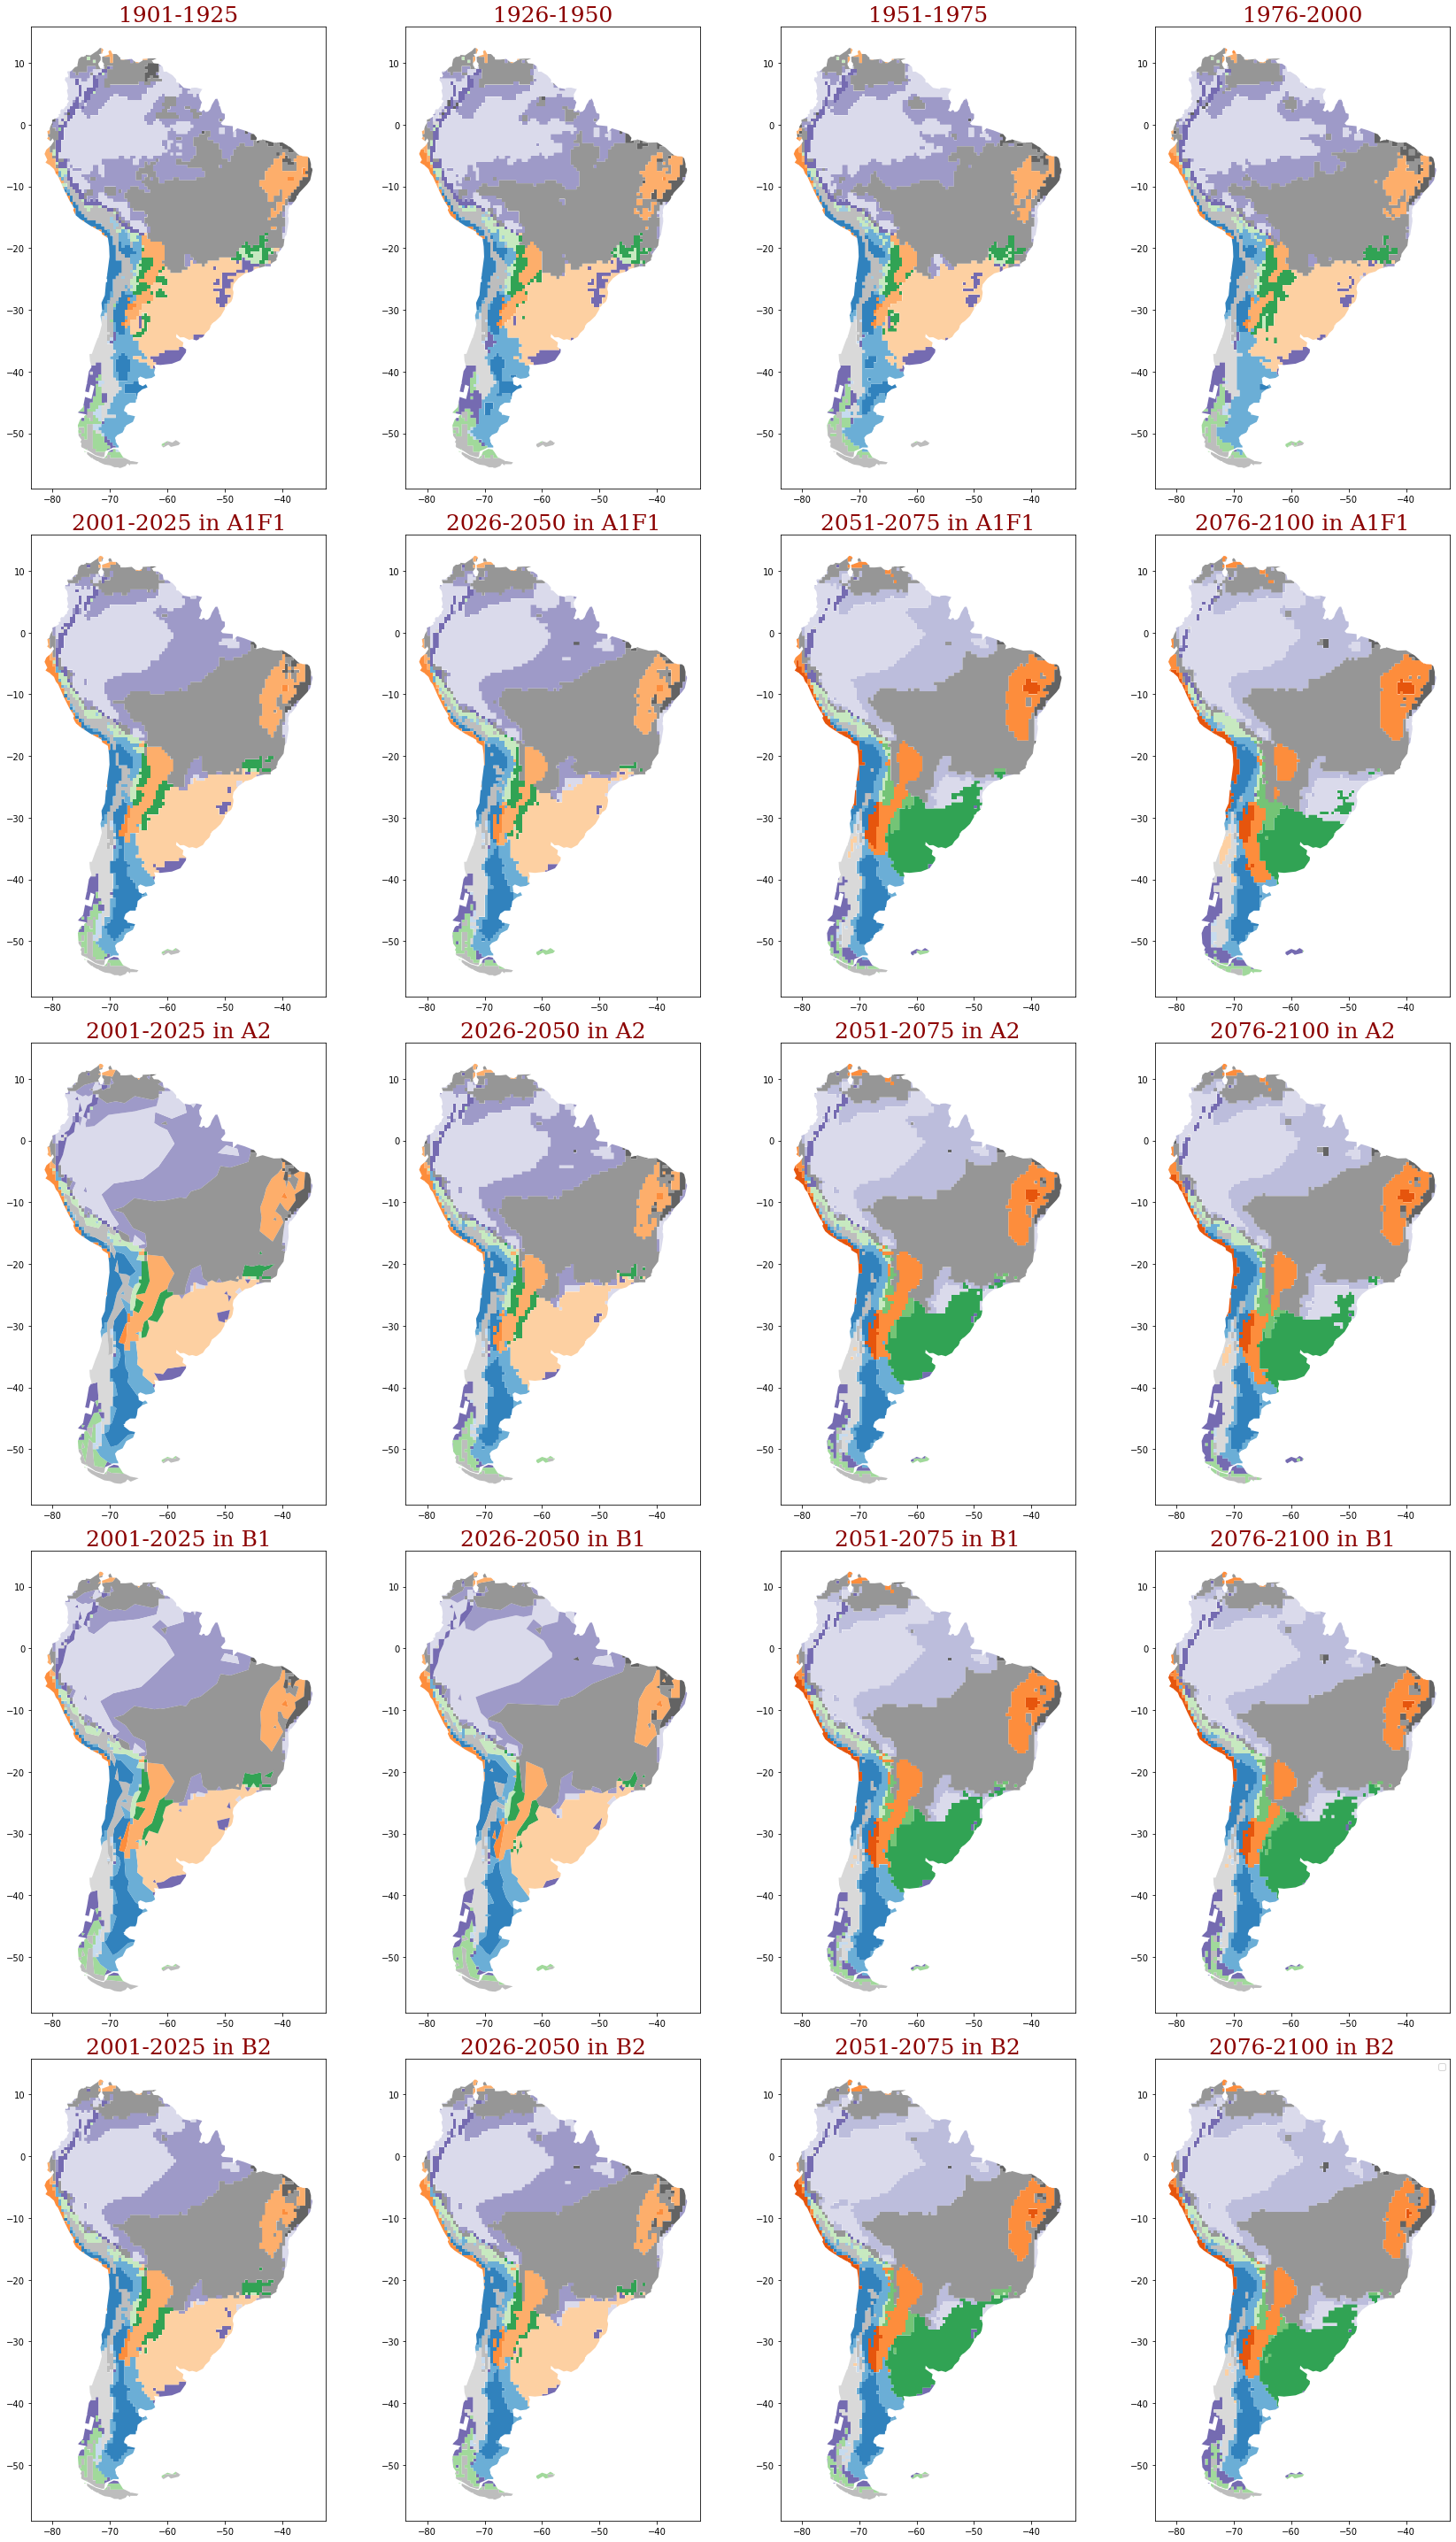

In [15]:
plot_shiftv(southamerica)

In [ ]:
# calculate the are and compare
soutamerica = get_area(southamerica)

# are calculation
south = pd.DataFrame(columns=['climate_shift','objectid', 'id', 'gridcode', 'shape_length', 'shape_area', 'geometry',
       'abb', 'koppen', 'area_km2'])
for i in soutamerica:
  name, df = i
  df['climate_shift'] = str(name)
  south = pd.concat([south, df], ignore_index=True)

# subsetting the dataframe
south = south[['climate_shift', 'abb', 'koppen', 'area_km2']].copy()

# groupby year
area_change = south.groupby(['climate_shift', 'abb', 'koppen']).agg('sum').reset_index()

# dataframe for plotting
climates_abb = area_change.abb.value_counts().index.to_list() # 18 graphs

## **Function to plot**

- `shift_print(df, clima, region)` for barplot to review the varition per Scenario
- `shift_plot(df_clima, region)` for (categorical) time series of the shift

> both work with the abbreviation of the Koppen-Geiger climate terminology. (3 letters)

* df - dataframe grouped with processed area
* clima - Koppen abbreviation
* region - zone for plot title

In [136]:
def shift_print(df, clima, region):
  ob= ['1901-1925', '1926-1950', '1951-1975', '1976-2000']
  af= ['2001-2025_A1F1', '2026-2050_A1F1', '2051-2075_A1F1', '2076-2100_A1F1']
  a2= ['2001-2025_A2', '2026-2050_A2', '2051-2075_A2', '2076-2100_A2']
  b1= ['2001-2025_B1', '2026-2050_B1', '2051-2075_B1', '2076-2100_B1']
  b2= ['2001-2025_B2', '2026-2050_B2', '2051-2075_B2', '2076-2100_B2']

  temp = df.loc[df.abb == clima].reset_index(drop=True)

  fig, ax = plt.subplots(1,4,figsize = (30, 8), facecolor='w', edgecolor='k')
  af = temp.loc[temp['climate_shift'].isin(ob + af)]
  sns.barplot(data= af, y = 'climate_shift', x = 'area_km2', ax=ax[0])
  ax[0].set_title('')
  a2 = temp.loc[temp['climate_shift'].isin(ob + a2)]
  sns.barplot(data= a2, y = 'climate_shift', x = 'area_km2', ax=ax[1])
  ax[1].set_title('')
  b1 = temp.loc[temp['climate_shift'].isin(ob + b1)]
  sns.barplot(data= b1, y = 'climate_shift', x = 'area_km2', ax=ax[2])
  ax[2].set_title('')
  b2 = temp.loc[temp['climate_shift'].isin(ob + b2)]
  sns.barplot(data= b2, y = 'climate_shift', x = 'area_km2', ax=ax[3])
  ax[3].set_title('')

  fig.suptitle('Analysis for Climate: ' + str(clima) + ' in ' + str(region), fontsize=30)
  plt.tight_layout(rect=[0, 0.03, 1, 0.90])
  plt.show()

In [137]:
def shift_plot(df, clima, region):
  ob= ['1901-1925', '1926-1950', '1951-1975', '1976-2000']
  af= ['2001-2025_A1F1', '2026-2050_A1F1', '2051-2075_A1F1', '2076-2100_A1F1']
  a2= ['2001-2025_A2', '2026-2050_A2', '2051-2075_A2', '2076-2100_A2']
  b1= ['2001-2025_B1', '2026-2050_B1', '2051-2075_B1', '2076-2100_B1']
  b2= ['2001-2025_B2', '2026-2050_B2', '2051-2075_B2', '2076-2100_B2']

  # Dict for renaming
  afd= {'2001-2025_A1F1':'2001-2025', '2026-2050_A1F1':'2026-2050', 
        '2051-2075_A1F1':'2051-2075', '2076-2100_A1F1':'2076-2100'}
  a2d= {'2001-2025_A2':'2001-2025', '2026-2050_A2':'2026-2050',
        '2051-2075_A2':'2051-2075', '2076-2100_A2':'2076-2100'}
  b1d= {'2001-2025_B1':'2001-2025', '2026-2050_B1':'2026-2050',
        '2051-2075_B1':'2051-2075', '2076-2100_B1':'2076-2100'}
  b2d= {'2001-2025_B2':'2001-2025', '2026-2050_B2':'2026-2050', 
        '2051-2075_B2':'2051-2075', '2076-2100_B2':'2076-2100'}

  temp = df.loc[df.abb == clima].reset_index(drop=True)

  fig, ax = plt.subplots(figsize = (10, 5), facecolor='w', edgecolor='k')

  af = temp.loc[temp['climate_shift'].isin(ob + af)].copy()
  af.climate_shift.replace(afd, inplace=True)
  plt.plot('climate_shift', 'area_km2',  data= af, label='A1F1')

  a2 = temp.loc[temp['climate_shift'].isin(ob + a2)].copy()
  a2.climate_shift.replace(a2d, inplace=True)
  plt.plot('climate_shift', 'area_km2',  data= a2, label='A2')
  
  b1 = temp.loc[temp['climate_shift'].isin(ob + b1)].copy()
  b1.climate_shift.replace(b1d, inplace=True)
  plt.plot('climate_shift', 'area_km2',  data= b1, label='B1')

  b2 = temp.loc[temp['climate_shift'].isin(ob + b2)].copy()
  b2.climate_shift.replace(b2d, inplace=True)
  plt.plot('climate_shift', 'area_km2',  data= b2, label='B2')

  fig.suptitle('Analysis for Climate: ' + str(clima) + ' in ' + str(region), fontsize=30)
  ax.legend()
  plt.xticks(rotation=75)
  plt.tight_layout(rect=[0, 0.03, 1, 0.90])
  plt.show()

## **Testing variation in climate per each Scenario in South America**

Test only show the first 5 climates.

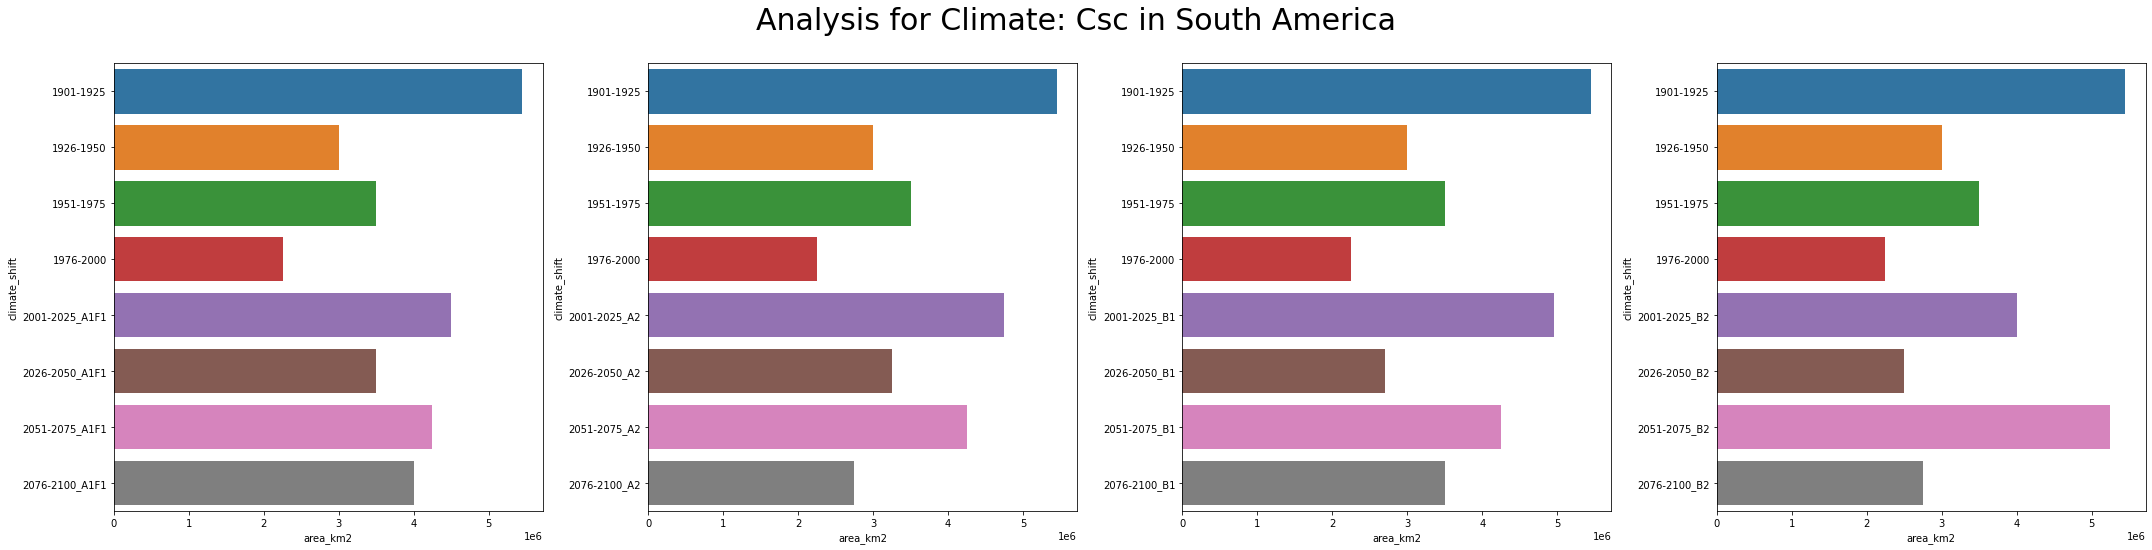

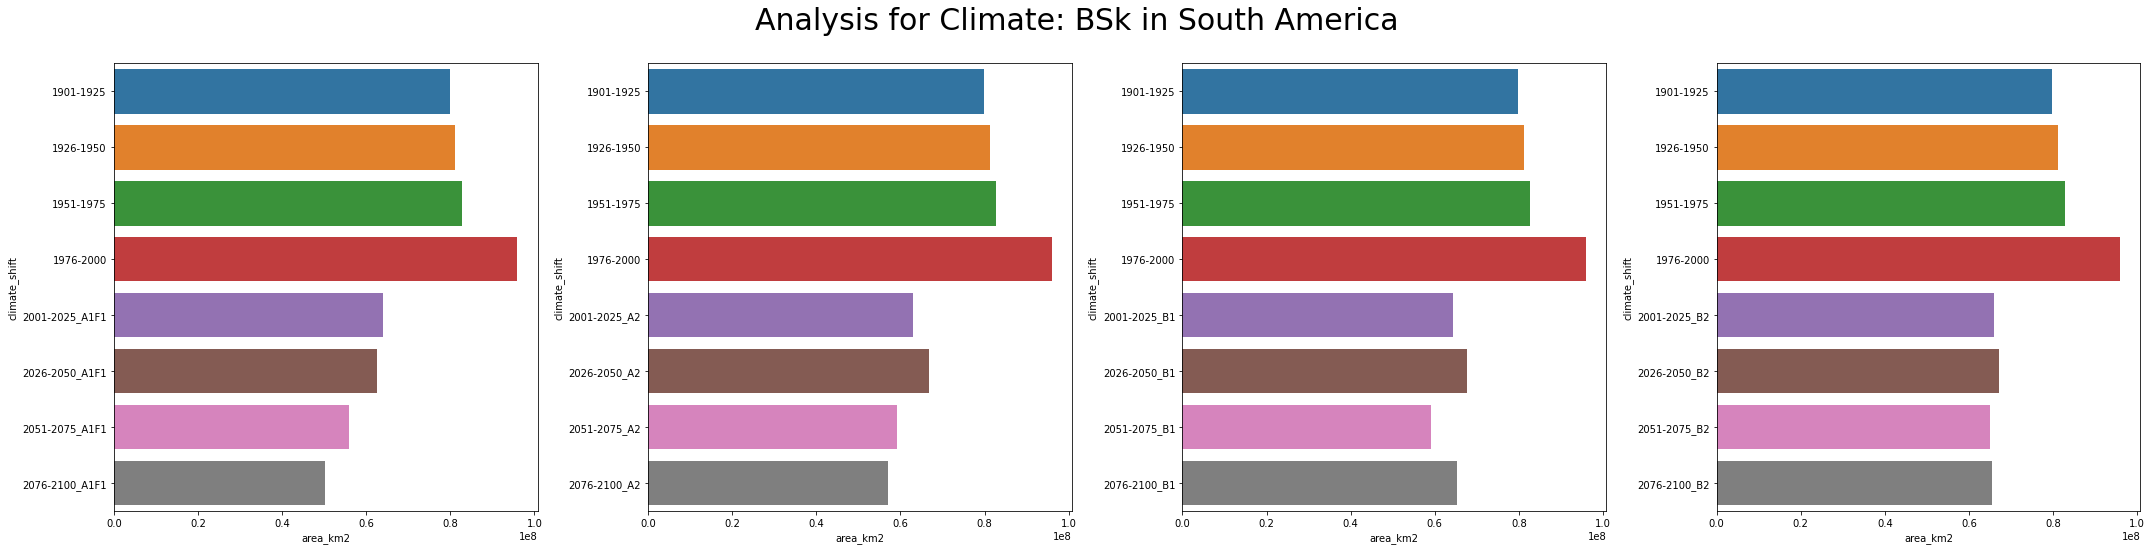

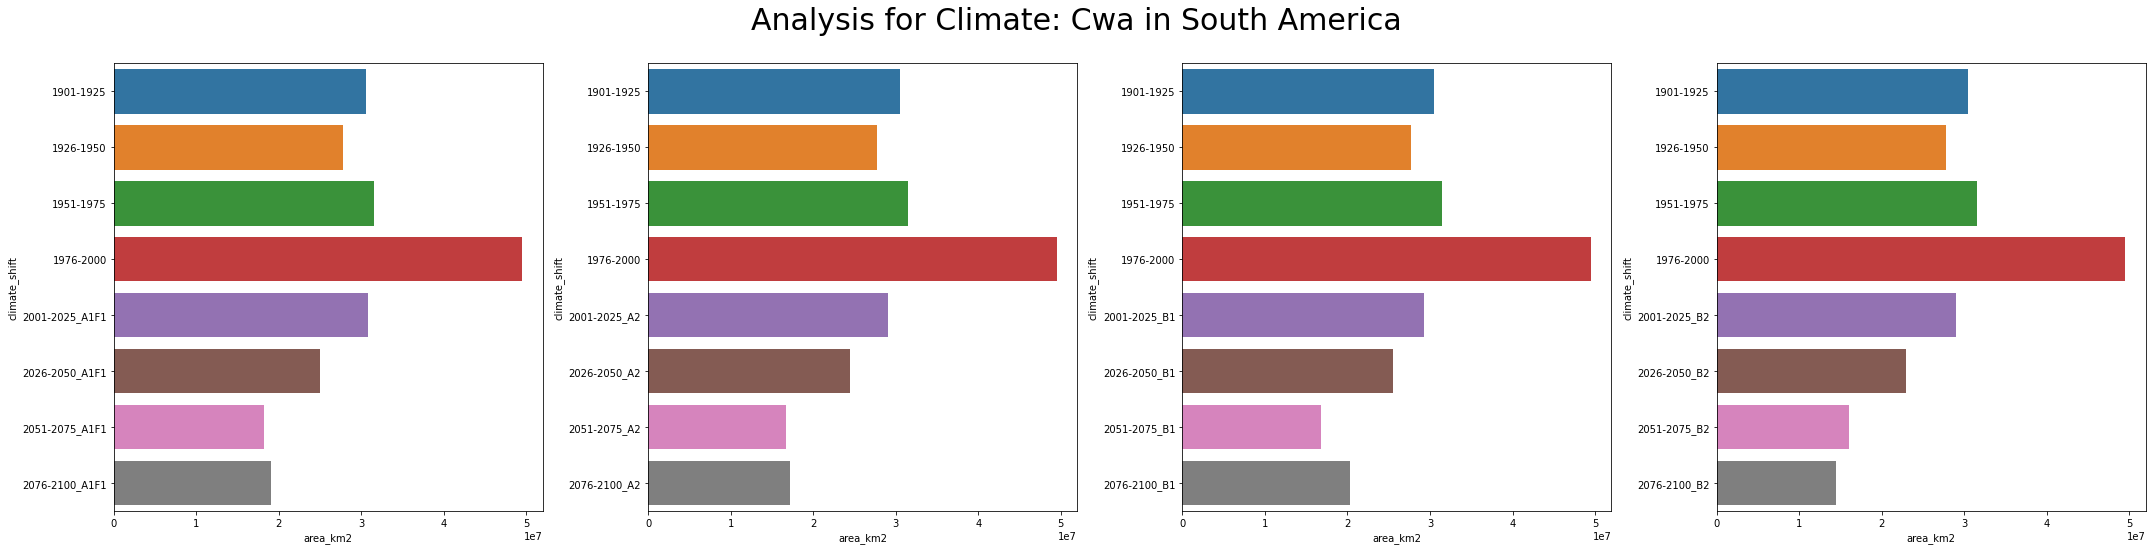

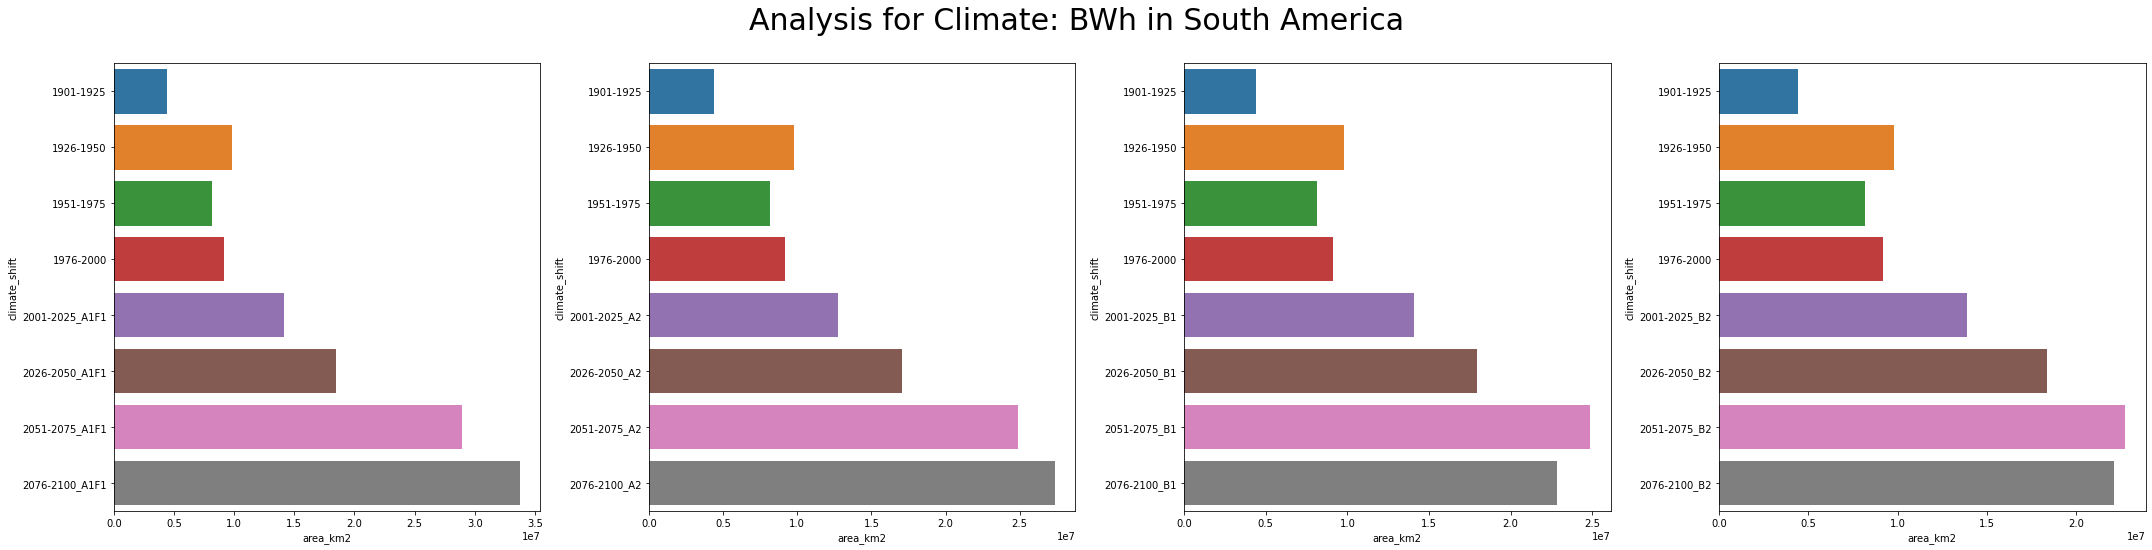

In [138]:
for i in climates_abb[:4]:
  shift_print(area_change, i, 'South America')
  print()

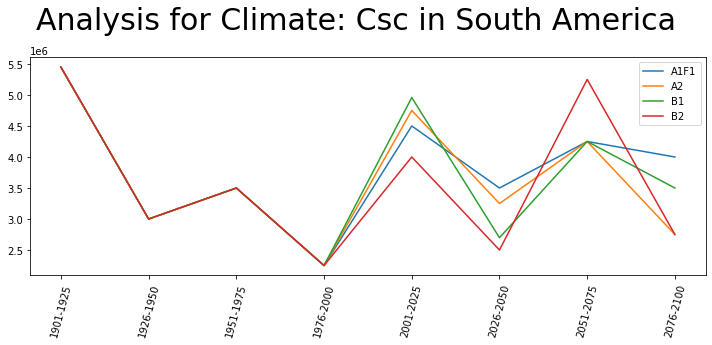

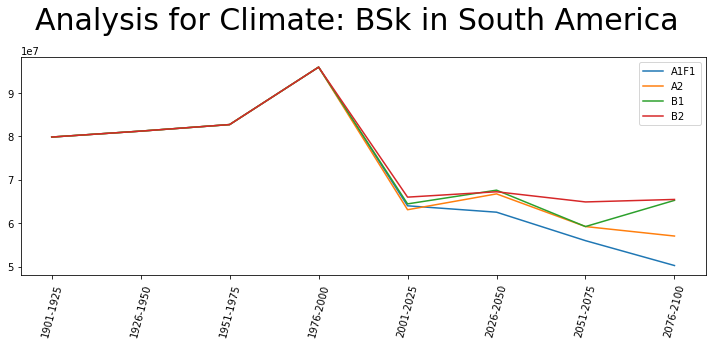

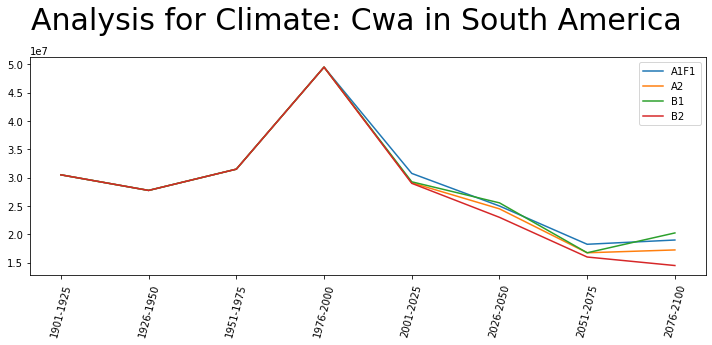

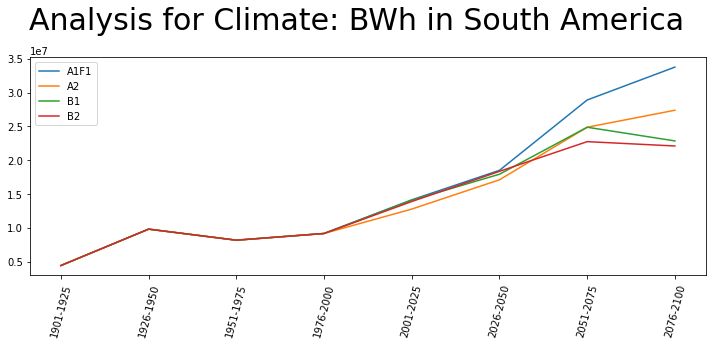

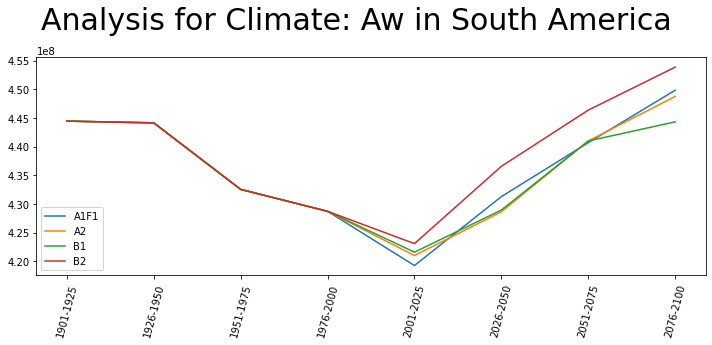

In [139]:
# plot the first 5 climate types
for i in climates_abb[:5]:
  shift_plot(area_change, i,'South America')
  print()

# **Analysis in Peru**

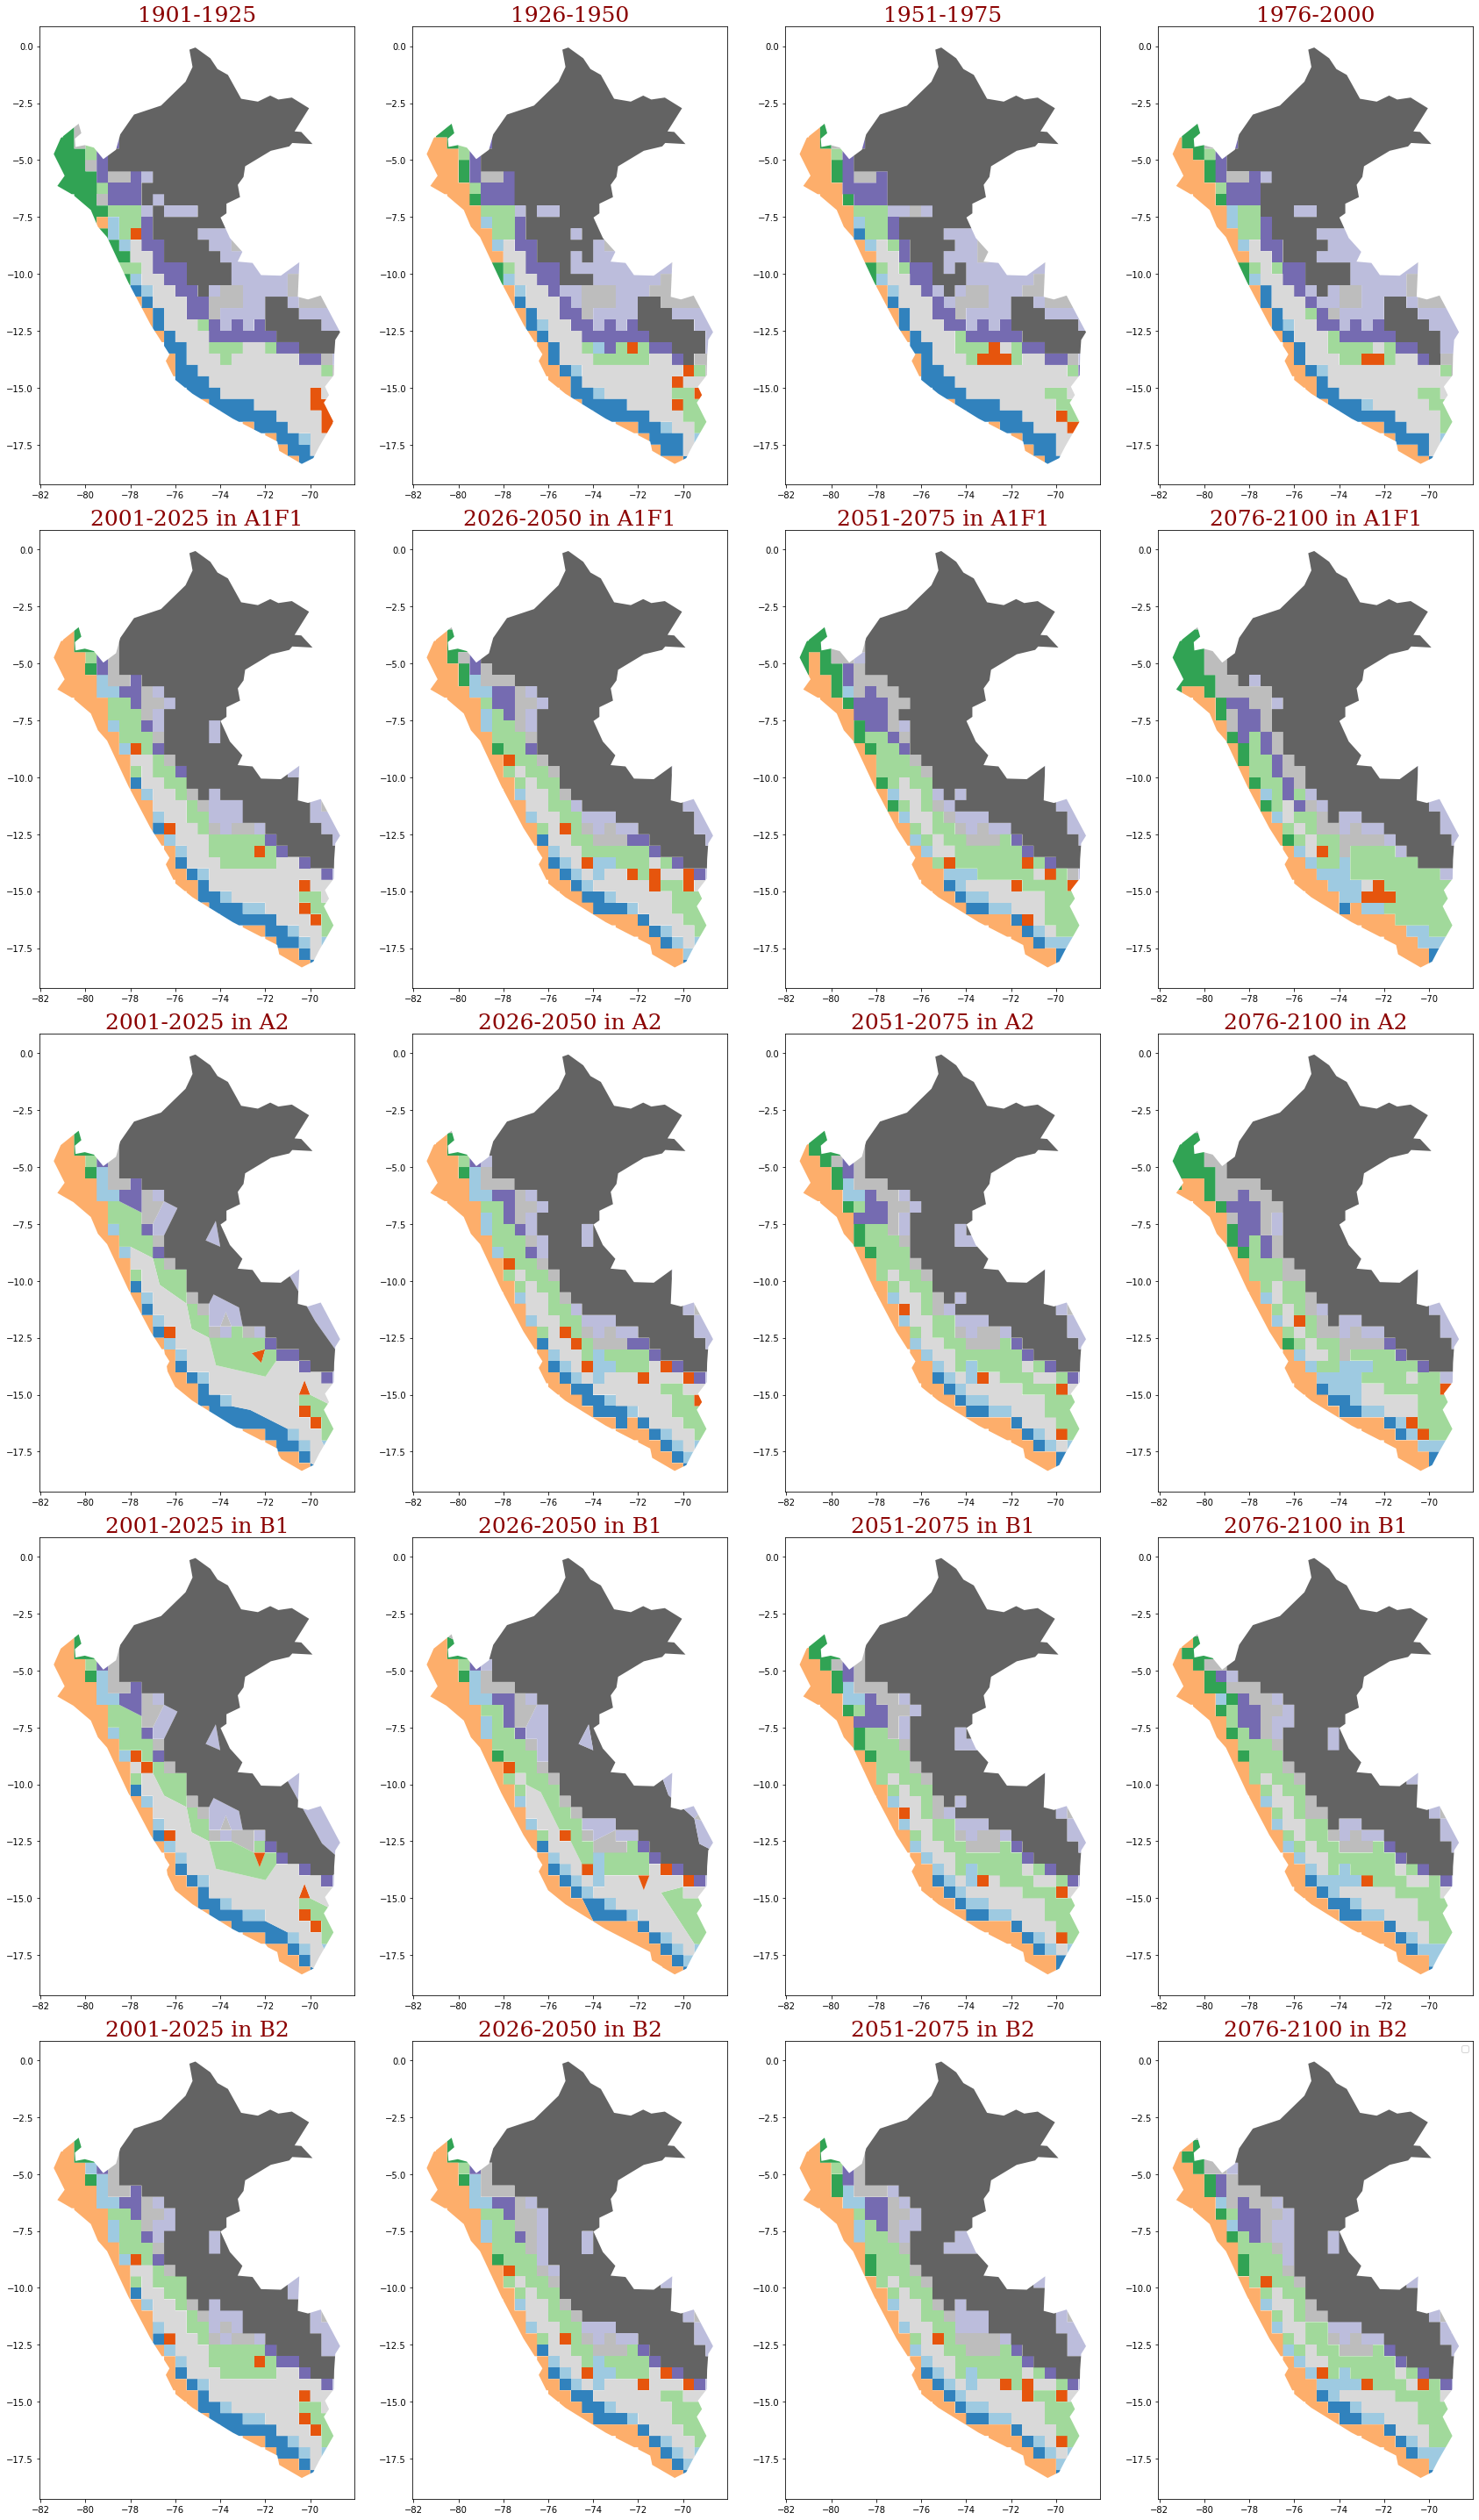

In [143]:
plot_shiftv(peru)

In [ ]:
# calculate the are and compare
peru_area = get_area(peru)

# are calculation
peru2 = pd.DataFrame(columns=['climate_shift','objectid', 'id', 'gridcode', 'shape_length', 'shape_area', 'geometry',
       'abb', 'koppen', 'area_km2'])
for i in peru_area:
  name, df = i
  df['climate_shift'] = str(name)
  peru2 = pd.concat([peru2, df], ignore_index=True)

# subsetting the dataframe
peru2 = peru2[['climate_shift', 'abb', 'koppen', 'area_km2']].copy()

# groupby year
area_change_peru = peru2.groupby(['climate_shift', 'abb', 'koppen']).agg('sum').reset_index()

# dataframe for plotting
climates_abb_peru = area_change_peru.abb.value_counts().index.to_list() # 18 graphs

## **Testing variation in climate per each Scenario in Peru**

Test only show the first 5 climates.

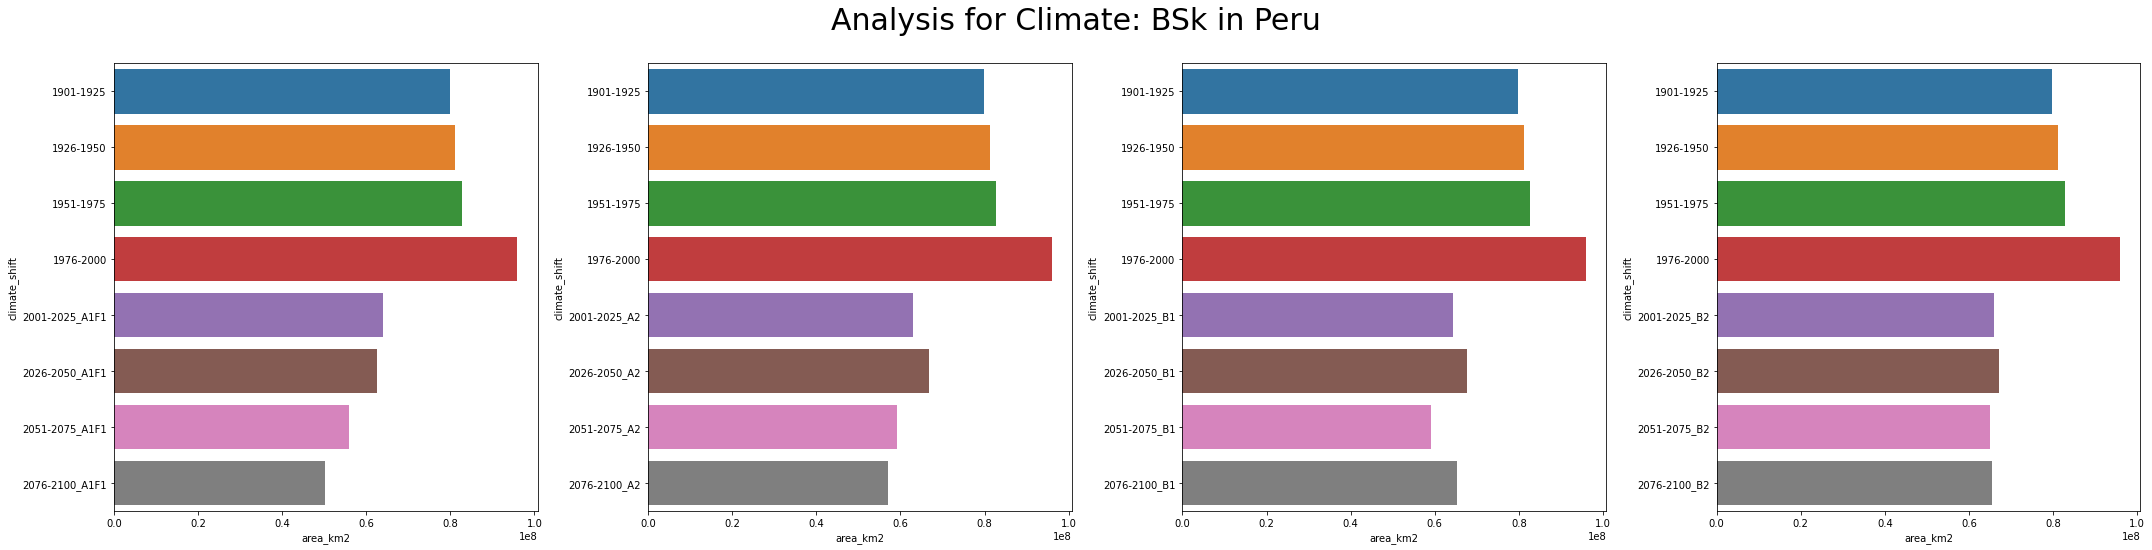

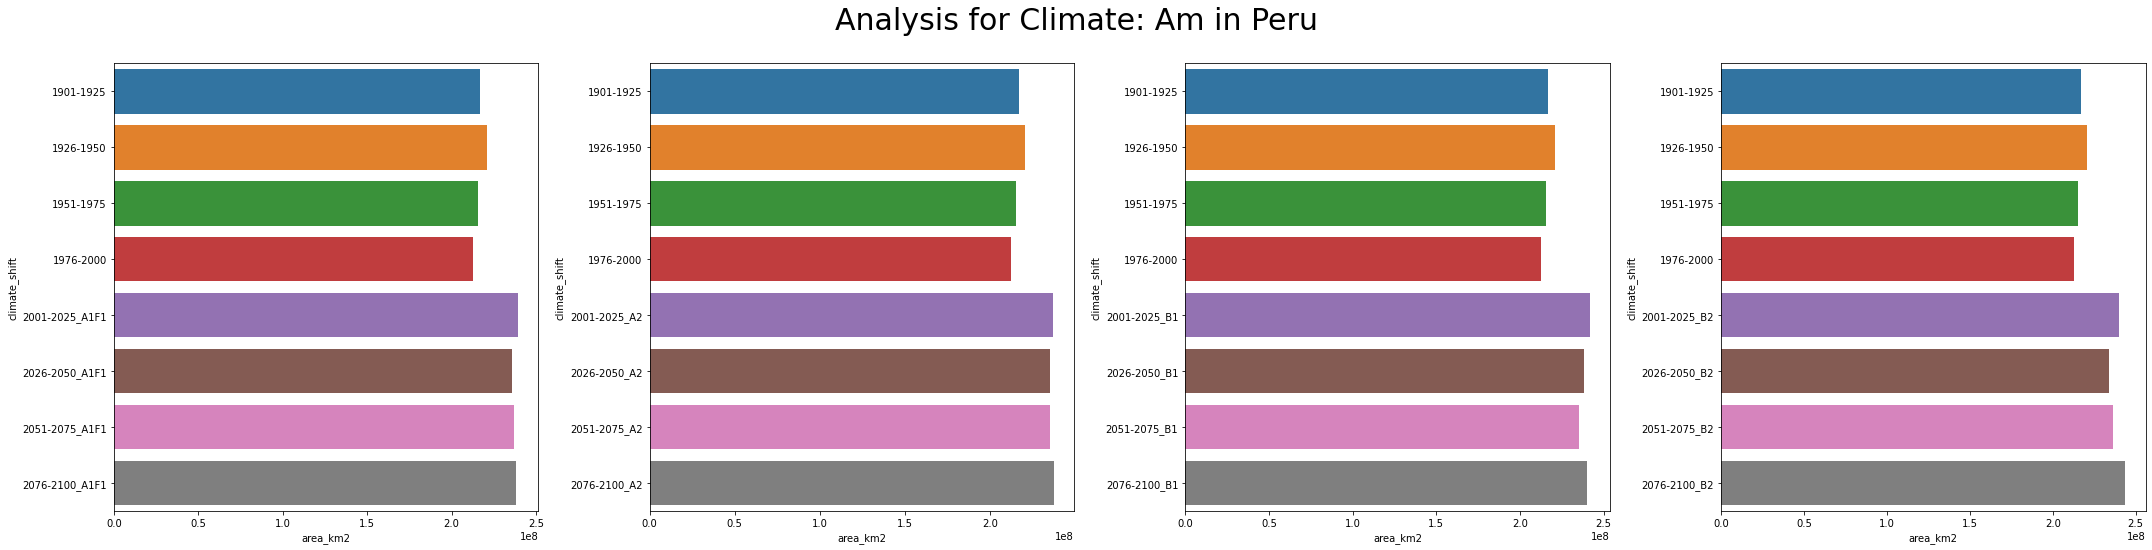

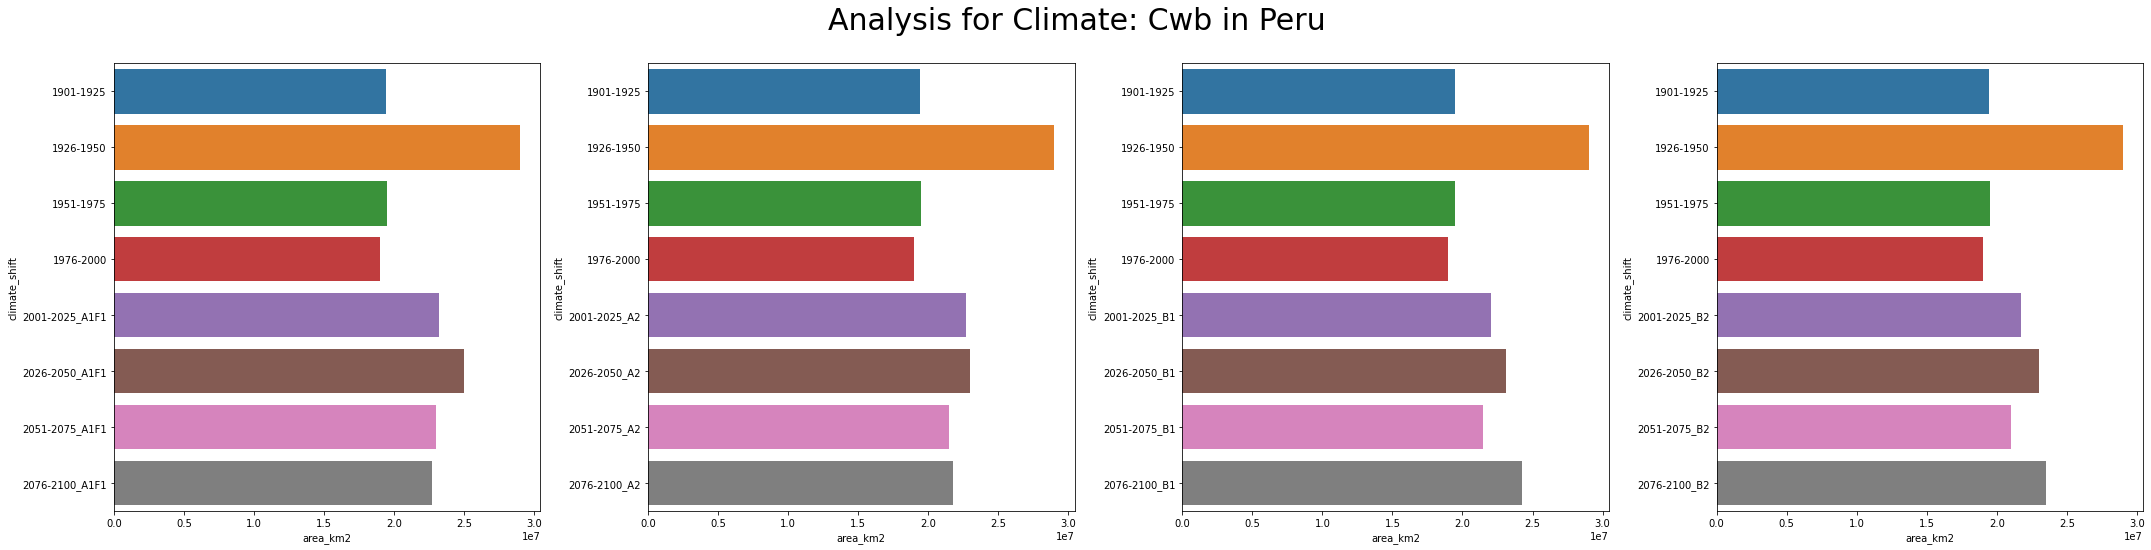

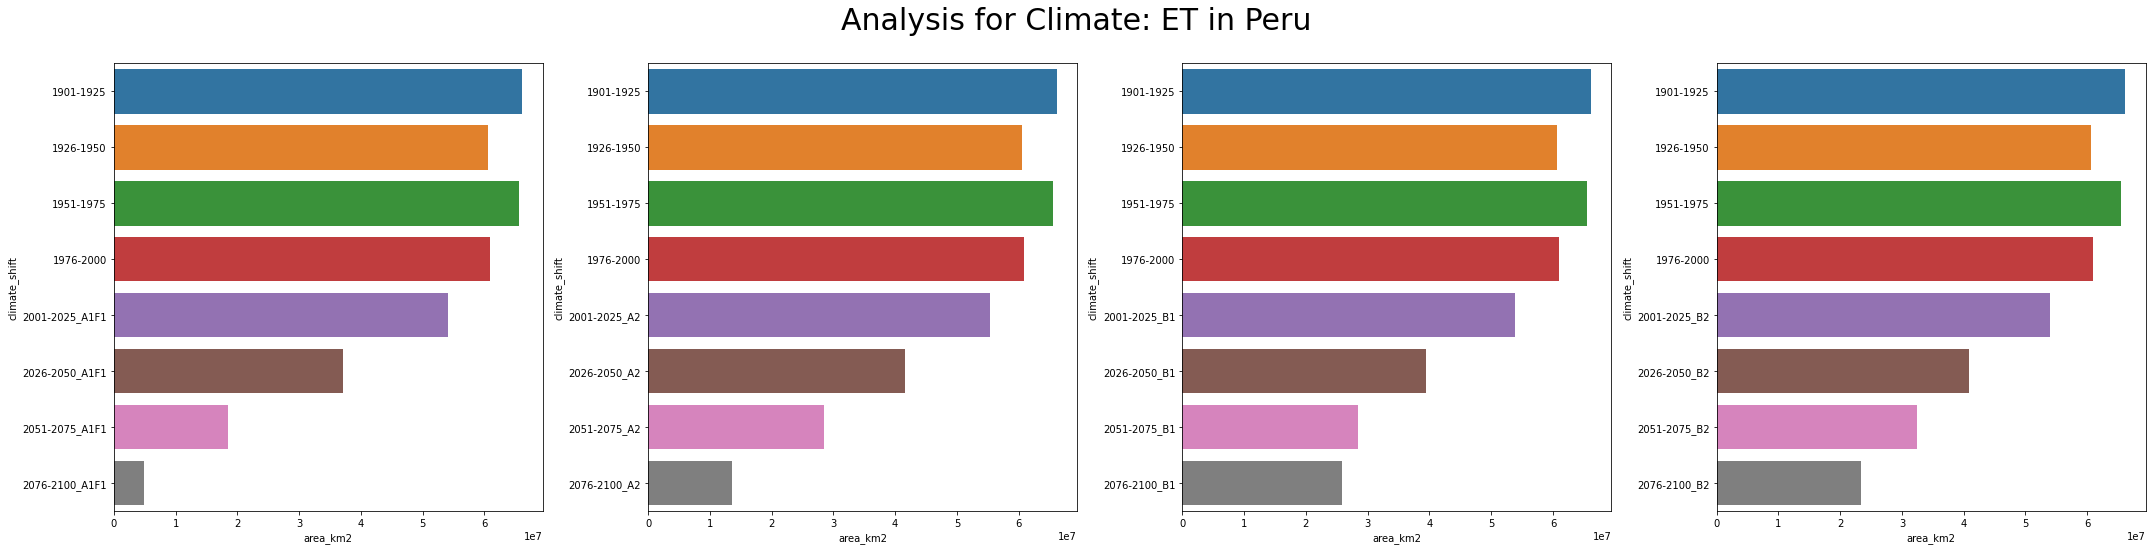

In [150]:
for i in climates_abb_peru[:4]:
  shift_print(area_change, i, 'Peru')
  print()

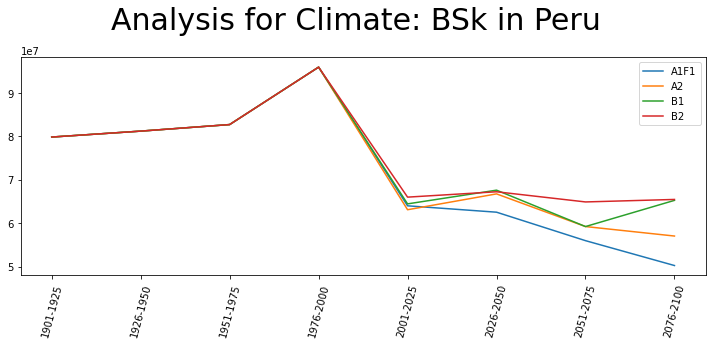

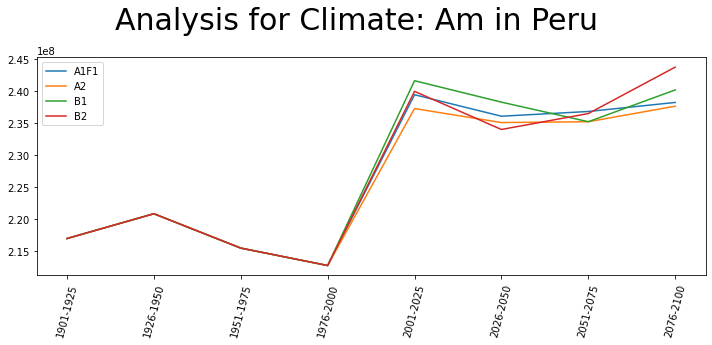

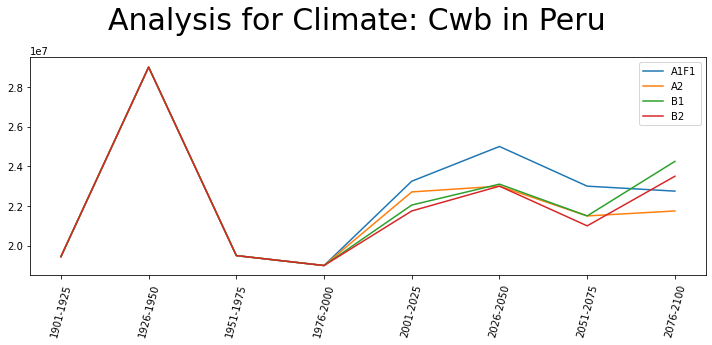

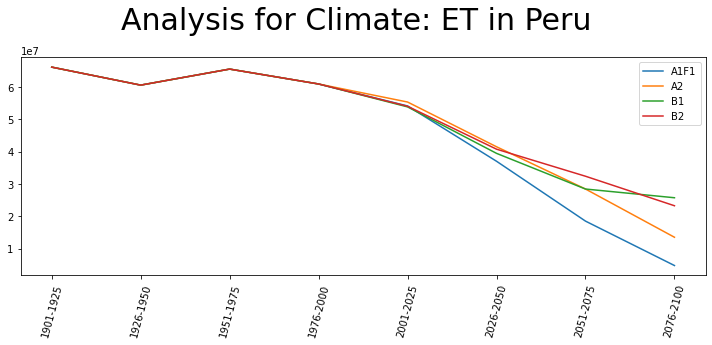

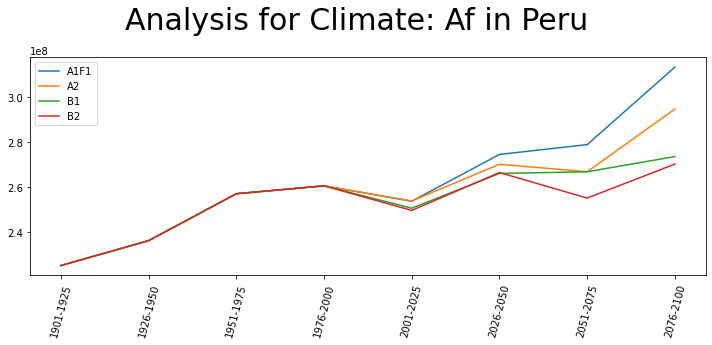

In [151]:
# plot the first 5 climate types
for i in climates_abb_peru[:5]:
  shift_plot(area_change, i,'Peru')
  print()

# **Analysis in Region**

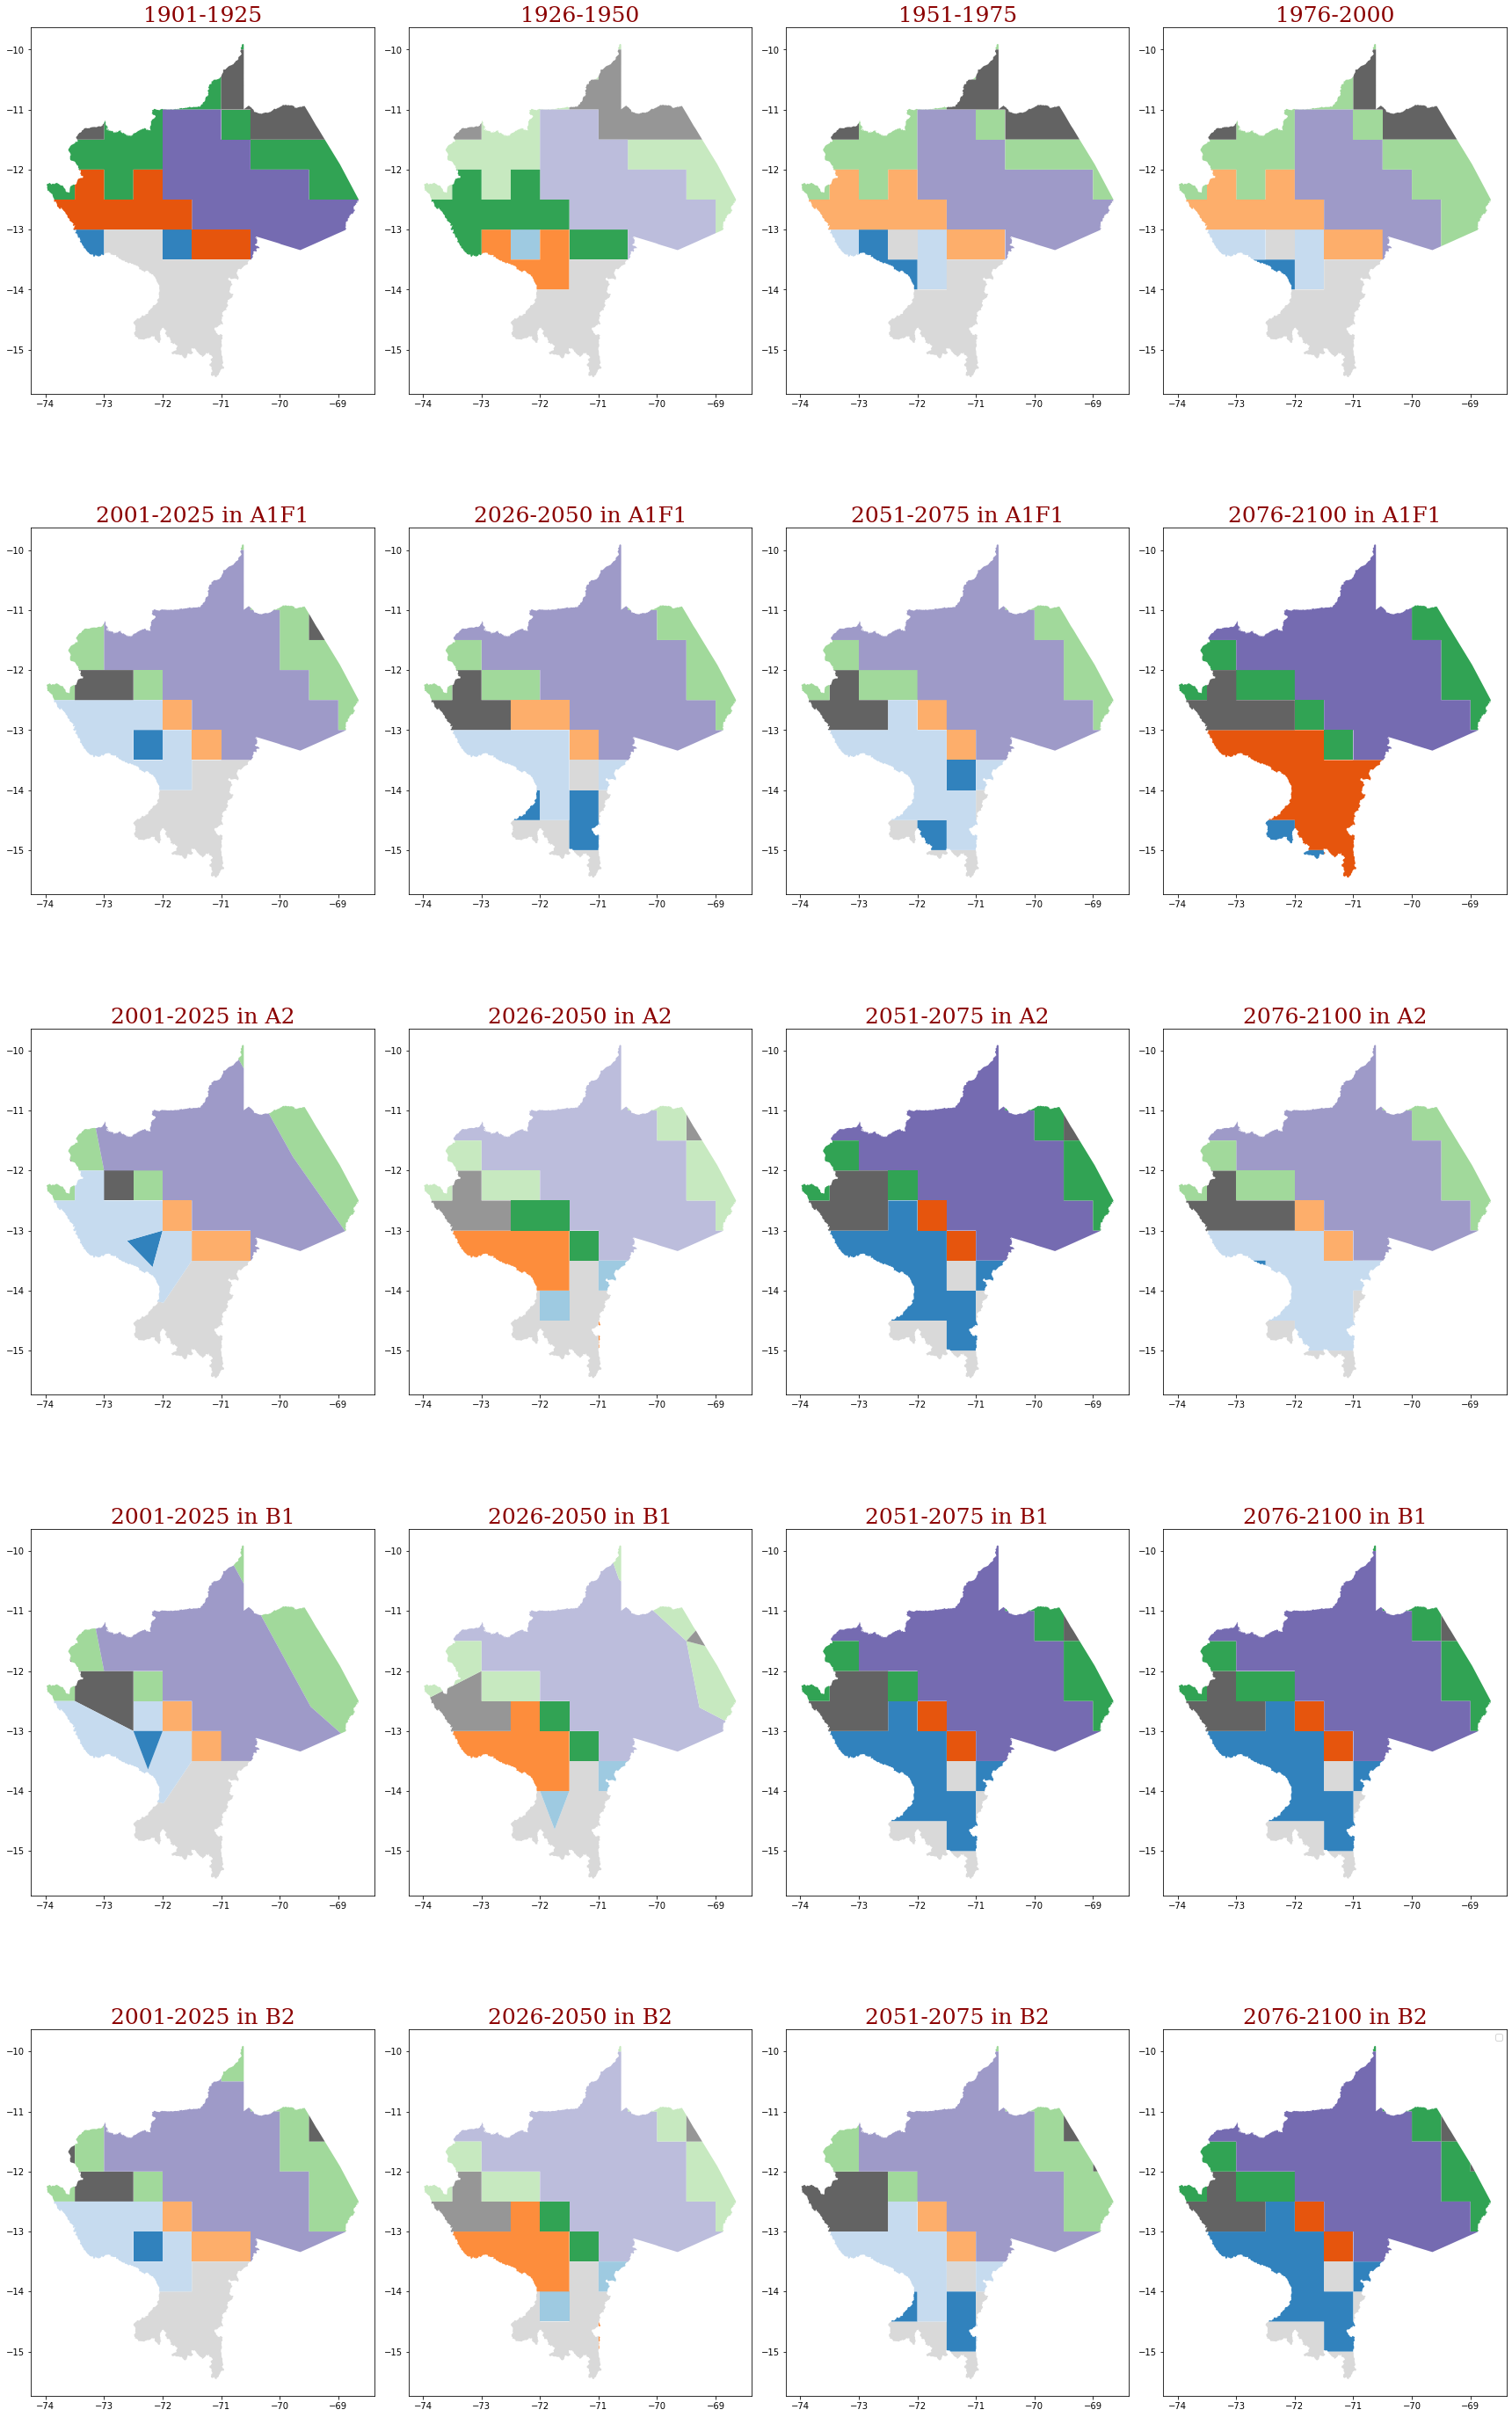

In [145]:
plot_shiftv(region_estudio)

In [ ]:
# calculate the are and compare
region_area = get_area(region_estudio)

# are calculation
region2 = pd.DataFrame(columns=['climate_shift','objectid', 'id', 'gridcode', 'shape_length', 'shape_area', 'geometry',
       'abb', 'koppen', 'area_km2'])
for i in region_area:
  name, df = i
  df['climate_shift'] = str(name)
  region2 = pd.concat([region2, df], ignore_index=True)

# subsetting the dataframe
region2 = region2[['climate_shift', 'abb', 'koppen', 'area_km2']].copy()

# groupby year
area_change_region = region2.groupby(['climate_shift', 'abb', 'koppen']).agg('sum').reset_index()

# dataframe for plotting
climates_abb_region = area_change_region.abb.value_counts().index.to_list() # 18 graphs

## **Testing variation in climate per each Scenario in Region**

Test only show the first 5 climates.

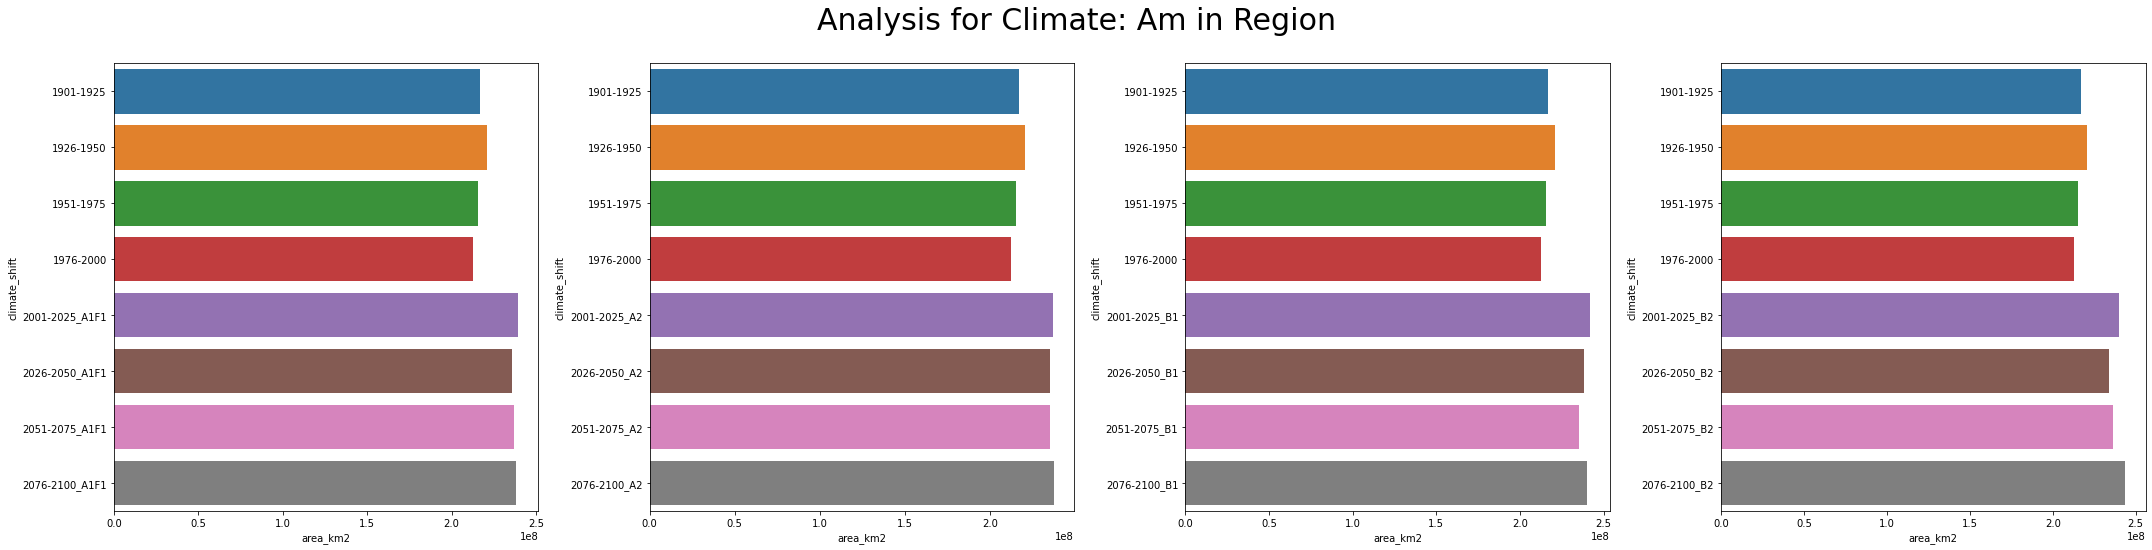

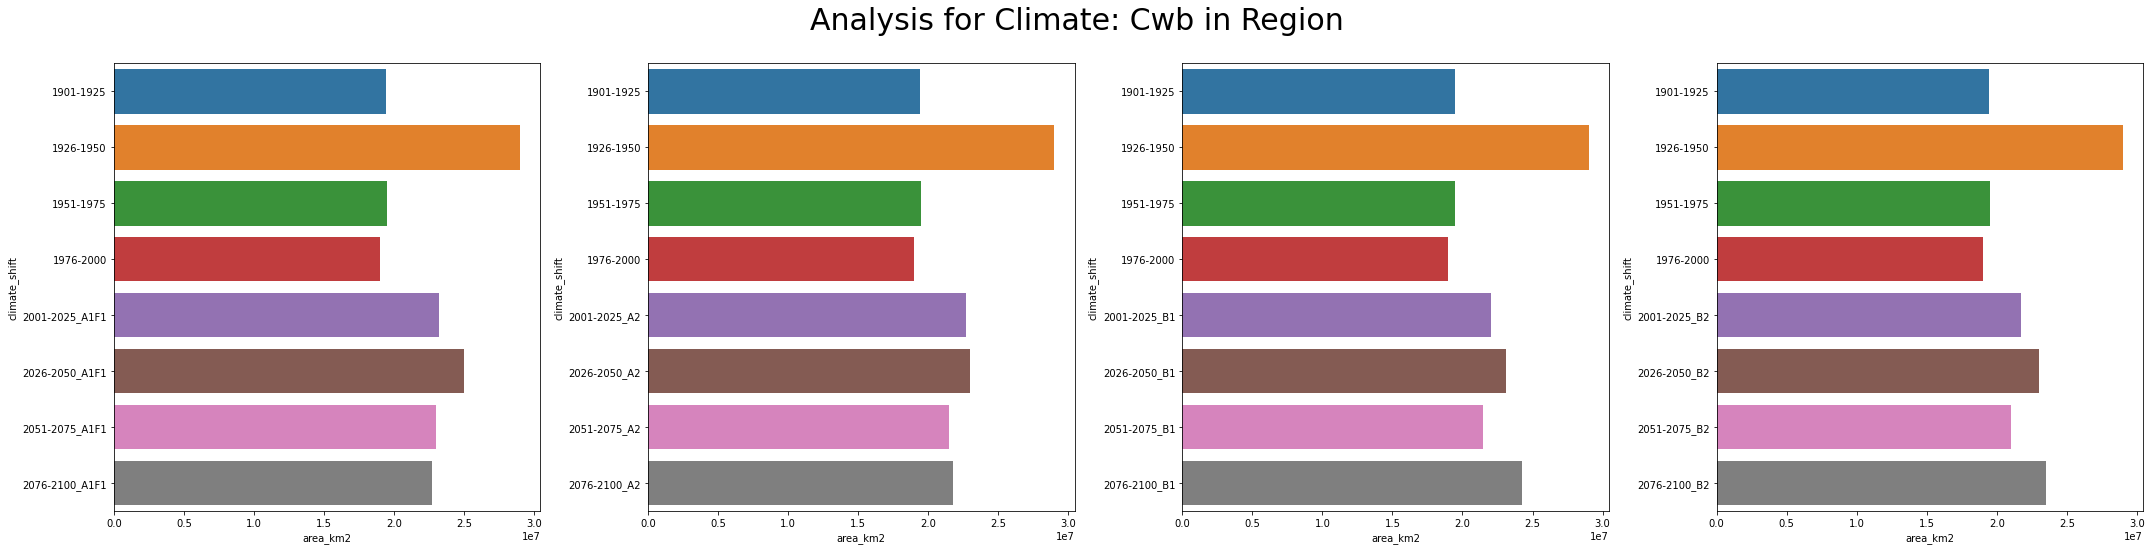

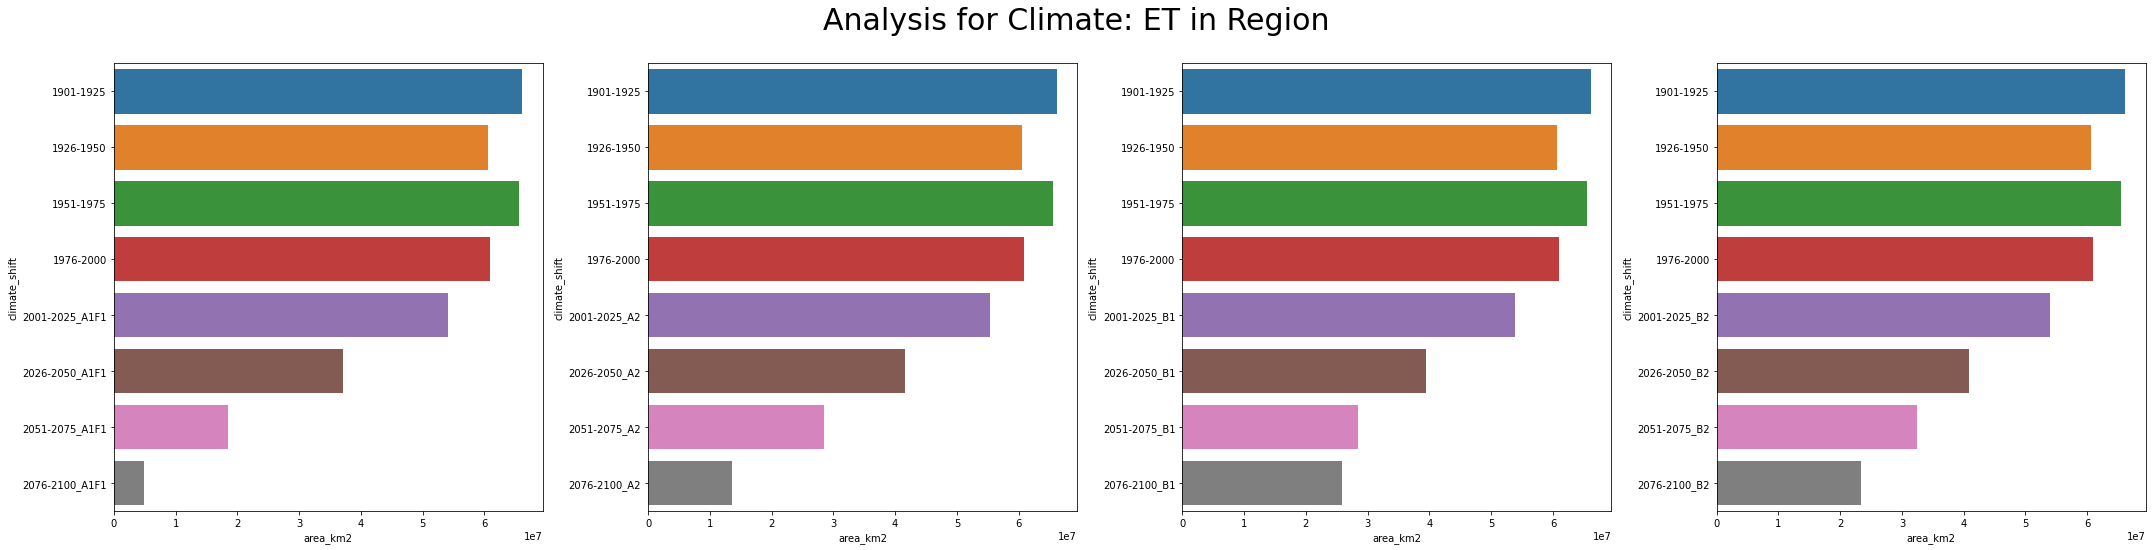

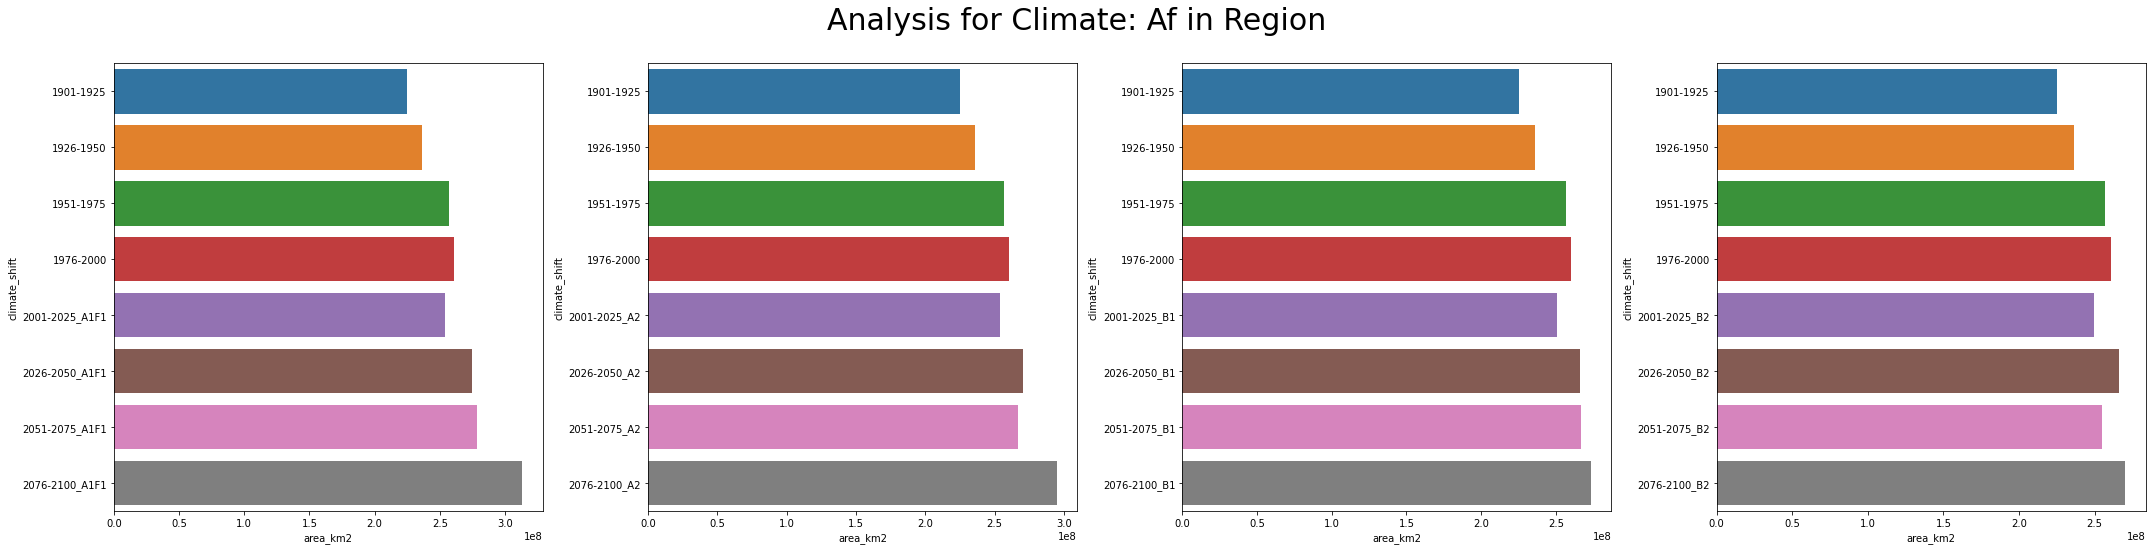

In [154]:
for i in climates_abb_region[:4]:
  shift_print(area_change, i, 'Region')
  print()

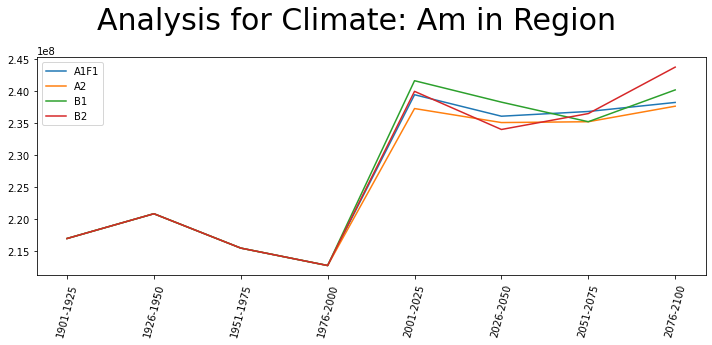

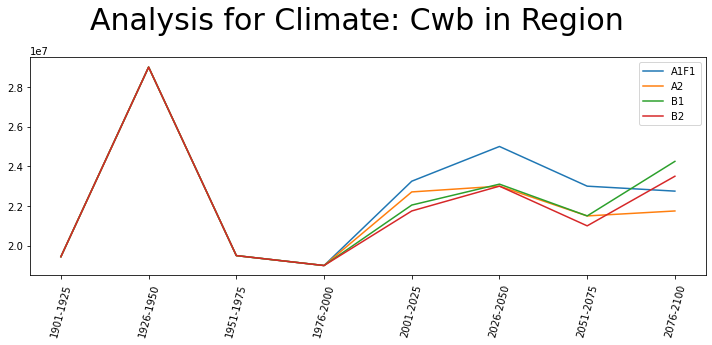

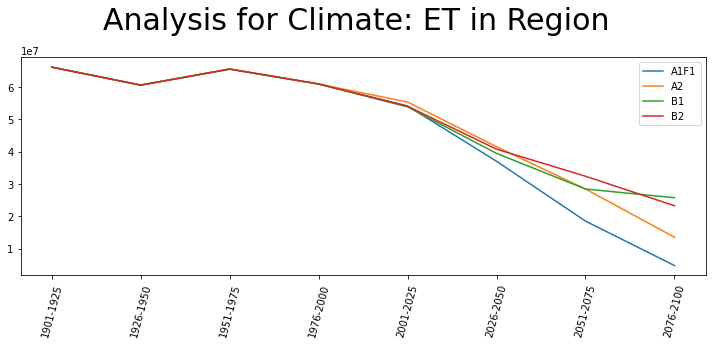

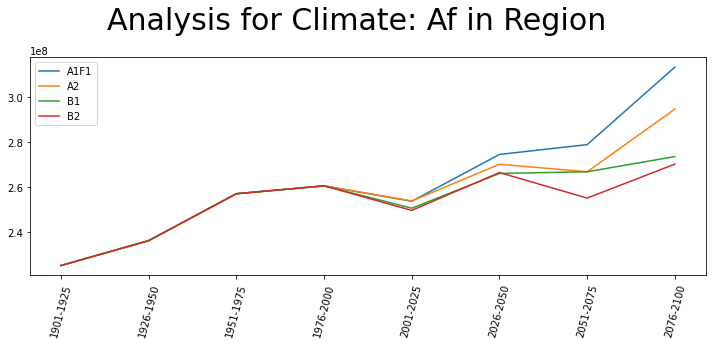

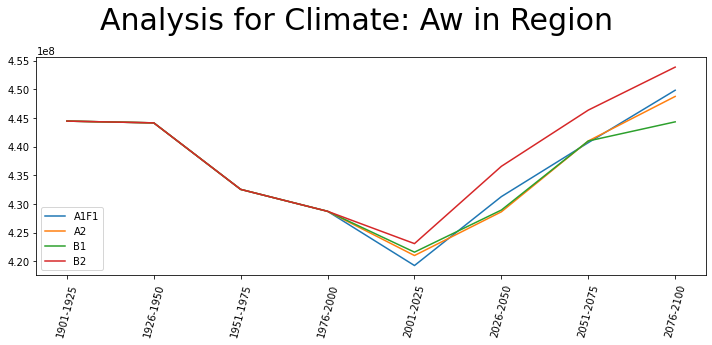

In [153]:
# plot the first 5 climate types
for i in climates_abb_region[:5]:
  shift_plot(area_change, i,'Region')
  print()